In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as patches
import time
from numba import jit
from IPython.core.display import display, HTML

In [2]:
display(HTML("<style>.container {width: 90% !important; }</style>"))

In [3]:
import warnings
warnings.filterwarnings('ignore') # setting ignore as a parameter

In [4]:
@jit
def upwind1_ue(AE,AP,ue,dy):
    AP+=dy*(abs(ue)+ue)
    AE-=dy*(abs(ue)-ue)
    
    return AE,AP

In [5]:
@jit
def upwind1_uw(AW,AP,uw,dy):
    AP+=dy*(abs(uw)-uw)
    AW-=dy*(abs(uw)+uw)
    
    return AW,AP

In [6]:
@jit
def upwind1_vn(AN,AP,vn,dx):
    AP+=dx*(abs(vn)+vn)
    AN-=dx*(abs(vn)-vn)

    return AN,AP

In [7]:
@jit
def upwind1_vs(AS,AP,vs,dx):
    AP+=dx*(abs(vs)-vs)
    AS-=dx*(abs(vs)+vs)
    
    return AS,AP

In [8]:
@jit
def central_diff_ue(AE,AP,ue,dy):
    AP+=dy*ue
    AE+=dy*ue
    
    return AE,AP

In [9]:
@jit
def central_diff_uw(AW,AP,uw,dy):
    AP-=dy*uw
    AW-=dy*uw
    
    return AW,AP

In [10]:
@jit
def central_diff_vn(AN,AP,vn,dx):
    AP+=dx*vn
    AN+=dx*vn
    
    return AN,AP

In [11]:
@jit
def central_diff_vs(AS,AP,vs,dx):
    AP-=dx*vs
    AS-=dx*vs
    
    return AS,AP

In [12]:
@jit
def hybrid(AE,AW,AN,AS,AP,ue,uw,vn,vs,dy,dx,v):
           
    Pe_e=ue*dx/v
    Pe_w=uw*dx/v
    Pe_n=vn*dy/v
    Pe_s=vs*dy/v
    
    if np.abs(Pe_e)<2:
        AE,AP=central_diff_ue(AE,AP,ue,dy)
    else:
        AE,AP=upwind1_ue(AE,AP,ue,dy)
    
    if np.abs(Pe_w)<2:  
        AW,AP=central_diff_uw(AW,AP,uw,dy)
    else:
        AW,AP=upwind1_uw(AW,AP,uw,dy)

    if np.abs(Pe_n)<2:
        AN,AP=central_diff_vn(AN,AP,vn,dx)
    else:
        AN,AP=upwind1_vn(AN,AP,vn,dx)

    if np.abs(Pe_s)<2:
        AS,AP=central_diff_vs(AS,AP,vs,dx)
    else:
        AS,AP=upwind1_vs(AS,AP,vs,dx)

    return AE,AW,AN,AS,AP

In [13]:
@jit
def mom_coeff(Nx,Ny,square_coord,U,V,P,E,v,u_inlet,dy,dx):
    N=Nx*Ny
    n_squares=square_coord.shape[1] 
    y=v*dx/dy
    x=v*dy/dx
    alpha=1+1/E
    
    uA=np.zeros([Ny,Nx,6])
    vA=np.zeros([Ny,Nx,6])
    DX=np.zeros([Ny,Nx])
    DY=np.zeros([Ny,Nx])
    
    a_s=0
    a_w=1
    a_p=2
    a_e=3
    a_n=4
    b_p=5
   
     #For interior cells
    for j in range(1,Ny-1):
        for i in range(1,Nx-1):
            
            VN=V[j+1][i]
            VP=V[j][i]
            VS=V[j-1][i]

            UE=U[j][i+1]
            UP=U[j][i]
            UW=U[j][i-1]
            
            ue=(UP+UE)/2
            uw=(UP+UW)/2
            vn=(VP+VN)/2
            vs=(VP+VS)/2

            AE=-2*x
            AW=-2*x
            AN=-2*y
            AS=-2*y
            AP=4*x+4*y
            
            AE,AW,AN,AS,AP=hybrid(AE,AW,AN,AS,AP,ue,uw,vn,vs,dy,dx,v) 
            
            uBP=dy*(P[j][i-1]-P[j][i+1])
            vBP=dx*(P[j-1][i]-P[j+1][i])

            Dx=dy/(AP*alpha-AE-AW-AN-AS)
            Dy=dx/(AP*alpha-AE-AW-AN-AS)

            uA[j][i][a_w]=AW
            uA[j][i][a_p]=AP
            uA[j][i][a_e]=AE
            uA[j][i][a_n]=AN
            uA[j][i][a_s]=AS
            uA[j][i][b_p]=uBP

            vA[j][i][a_w]=AW
            vA[j][i][a_p]=AP
            vA[j][i][a_e]=AE
            vA[j][i][a_n]=AN
            vA[j][i][a_s]=AS
            vA[j][i][b_p]=vBP

            DX[j][i]=Dx
            DY[j][i]=Dy
            
    #for bottom wall
    j=0
    for i in range(1,Nx-1):
        
        UW=U[j][i-1]
        UP=U[j][i]
        UE=U[j][i+1]

        VP=V[j][i]
        VN=V[j+1][i]
        
        ue=(UP+UE)/2
        uw=(UP+UW)/2
        vn=(VP+VN)/2

        AE=-2*x
        AW=-2*x
        AN=-(8/3)*y
        AP=8*y+4*x

        AE,AW,AN,AS,AP=hybrid(AE,AW,AN,AS,AP,ue,uw,vn,1E-12,dy,dx,v)

        uBP=dy*(P[j][i-1]-P[j][i+1])
        vBP=dx*(P[j][i]-P[j+1][i])
        Dx=dy/(AP*alpha-AE-AW-AN)
        Dy=dx/(AP*alpha-AE-AW-AN)

        uA[j][i][a_w]=AW
        uA[j][i][a_p]=AP
        uA[j][i][a_e]=AE
        uA[j][i][a_n]=AN
        uA[j][i][b_p]=uBP

        vA[j][i][a_w]=AW
        vA[j][i][a_p]=AP
        vA[j][i][a_e]=AE
        vA[j][i][a_n]=AN
        vA[j][i][b_p]=vBP

        DX[j][i]=Dx
        DY[j][i]=Dy

    #for top wall
    j=Ny-1
    for i in range(1,Nx-1):
        
        UW=U[j][i-1]
        UP=U[j][i]
        UE=U[j][i+1]
            
        VP=V[j][i]
        VS=V[j-1][i]
        
        ue=(UP+UE)/2
        uw=(UP+UW)/2
        vs=(VP+VS)/2

        AE=-2*x
        AW=-2*x
        AS=-(8/3)*y
        AP=8*y+4*x
        
        AE,AW,AN,AS,AP=hybrid(AE,AW,AN,AS,AP,ue,uw,1E-12,vs,dy,dx,v)
        
        uBP=dy*(P[j][i-1]-P[j][i+1])
        vBP=dx*(P[j-1][i]-P[j][i])         
        Dx=dy/(AP*alpha-AE-AW-AS)
        Dy=dx/(AP*alpha-AE-AW-AS)

        uA[j][i][a_w]=AW
        uA[j][i][a_p]=AP
        uA[j][i][a_e]=AE
        uA[j][i][a_s]=AS
        uA[j][i][b_p]=uBP

        vA[j][i][a_w]=AW
        vA[j][i][a_p]=AP
        vA[j][i][a_e]=AE
        vA[j][i][a_s]=AS
        vA[j][i][b_p]=vBP

        DX[j][i]=Dx
        DY[j][i]=Dy

    #for inlet:
    i=0
    for j in range(1,Ny-1):
        VN=V[j+1][i]
        VP=V[j][i]
        VS=V[j-1][i]

        UP=U[j][i]
        UE=U[j][i+1]
        
        u_in=u_inlet[j]
        ue=(UP+UE)/2
        vn=(VP+VN)/2
        vs=(VP+VS)/2

        AE=-(8/3)*x
        AN=-2*y
        AS=-2*y
        AP=8*x+4*y

        AE,AW,AN,AS,AP=hybrid(AE,AW,AN,AS,AP,ue,1E-12,vn,vs,dy,dx,v)

        uBP=dy*(P[j][i]-P[j][i+1])+(2*dy*u_in**2)+((16/3)*x*u_in)
        vBP=dx*(P[j-1][i]-P[j+1][i])
        Dx=dy/(AP*alpha-AE-AN-AS)
        Dy=dx/(AP*alpha-AE-AN-AS)

        uA[j][i][a_p]=AP
        uA[j][i][a_e]=AE
        uA[j][i][a_n]=AN
        uA[j][i][a_s]=AS
        uA[j][i][b_p]=uBP

        vA[j][i][a_p]=AP
        vA[j][i][a_e]=AE
        vA[j][i][a_n]=AN
        vA[j][i][a_s]=AS
        vA[j][i][b_p]=vBP

        DX[j][i]=Dx
        DY[j][i]=Dy

    #for right wall (outlet):
    i=Nx-1
    for j in range(1,Ny-1):
        
        VN=V[j+1][i]
        VP=V[j][i]
        VS=V[j-1][i]

        UP=U[j][i]
        UW=U[j][i-1]
        
        ue=1.5*UP-0.5*UW
        uw=(UP+UW)/2
        vn=(VP+VN)/2
        vs=(VP+VS)/2

        AW=-2*x
        AN=-2*y
        AS=-2*x
        AP=2*x+4*y+2*dy*ue

        AE,AW,AN,AS,AP=hybrid(AE,AW,AN,AS,AP,1E-12,uw,vn,vs,dy,dx,v)

        uBP=dy*(P[j][i-1]-P[j][i])
        vBP=dx*(P[j-1][i]-P[j+1][i])
        Dx=dy/(AP*alpha-AW-AN-AS)
        Dy=dx/(AP*alpha-AW-AN-AS)

        uA[j][i][a_w]=AW
        uA[j][i][a_p]=AP
        uA[j][i][a_n]=AN
        uA[j][i][a_s]=AS
        uA[j][i][b_p]=uBP

        vA[j][i][a_w]=AW
        vA[j][i][a_p]=AP
        vA[j][i][a_n]=AN
        vA[j][i][a_s]=AS
        vA[j][i][b_p]=vBP

        DX[j][i]=Dx
        DY[j][i]=Dy

    #top right cell
    i=Nx-1
    j=Ny-1
    
    UP=U[j][i]
    UW=U[j][i-1]
    
    VS=V[j-1][i]
    VP=V[j][i]
    
    ue=1.5*UP-0.5*UW
    uw=(UP+UW)/2
    vs=(VP+VS)/2
    
    AW=-2*x
    AS=-(8/3)*y
    AP=2*x+8*y+2*dy*ue
    
    AE,AW,AN,AS,AP=hybrid(AE,AW,AN,AS,AP,1E-12,uw,1E-12,vs,dy,dx,v)
    
    uBP=dy*(P[j][i-1]-P[j][i])
    vBP=dx*(P[j-1][i]-P[j][i])
    Dx=dy/(AP*alpha-AW-AS)
    Dy=dx/(AP*alpha-AW-AS)

    uA[j][i][a_w]=AW
    uA[j][i][a_p]=AP
    uA[j][i][a_s]=AS
    uA[j][i][b_p]=uBP

    vA[j][i][a_w]=AW
    vA[j][i][a_p]=AP
    vA[j][i][a_s]=AS
    vA[j][i][b_p]=vBP

    DX[j][i]=Dx
    DY[j][i]=Dy
    
    #top left cell
    i=0
    j=Ny-1
    
    UP=U[j][i]
    UE=U[j][i+1]
   
    VS=V[j-1][i]
    VP=V[j][i]

    u_in=u_inlet[j]
    ue=(UP+UE)/2
    vs=(VP+VS)/2
    
    AE=-(8/3)*x
    AS=-(8/3)*y
    AP=8*x+8*y

    AE,AW,AN,AS,AP=hybrid(AE,AW,AN,AS,AP,ue,1E-12,1E-12,vs,dy,dx,v)
    
    uBP=dy*(P[j][i]-P[j][i+1])+(2*dy*u_in**2)+((16/3)*x*u_in)
    vBP=dx*(P[j-1][i]-P[j][i])
    Dx=dy/(AP*alpha-AE-AS)
    Dy=dx/(AP*alpha-AE-AS)
    
    uA[j][i][a_p]=AP
    uA[j][i][a_e]=AE
    uA[j][i][a_s]=AS
    uA[j][i][b_p]=uBP

    vA[j][i][a_p]=AP
    vA[j][i][a_e]=AE
    vA[j][i][a_s]=AS
    vA[j][i][b_p]=vBP

    DX[j][i]=Dx
    DY[j][i]=Dy

    #bottom right cell
    i=Nx-1
    j=0
    
    UW=U[j][i-1]
    UP=U[j][i]

    VP=V[j][i]
    VN=V[j+1][i]
    
    ue=1.5*UP-0.5*UW
    uw=(UP+UW)/2
    vn=(VP+VN)/2
    
    AW=-2*x
    AN=-(8/3)*y
    AP=2*x+8*y+2*dy*ue

    AE,AW,AN,AS,AP=hybrid(AE,AW,AN,AS,AP,1E-12,uw,vn,1E-12,dy,dx,v)
   
    uBP=dy*(P[j][i-1]-P[j][i])
    vBP=dx*(P[j][i]-P[j+1][i])
    Dx=dy/(AP*alpha-AW-AN)
    Dy=dx/(AP*alpha-AW-AN)
    
    uA[j][i][a_w]=AW
    uA[j][i][a_p]=AP
    uA[j][i][a_n]=AN
    uA[j][i][b_p]=uBP

    vA[j][i][a_w]=AW
    vA[j][i][a_p]=AP
    vA[j][i][a_n]=AN
    vA[j][i][b_p]=vBP

    DX[j][i]=Dx
    DY[j][i]=Dy
    
    #bottom left cell
    i=0
    j=0
    
    UP=U[j][i]
    UE=U[j][i+1]

    VP=V[j][i]
    VN=V[j+1][i]

    u_in=u_inlet[j]
    ue=(UP+UE)/2
    vn=(VP+VN)/2
    
    AE=-(8/3)*x
    AN=-(8/3)*y
    AP=8*x+8*y
    
    AE,AW,AN,AS,AP=hybrid(AE,AW,AN,AS,AP,ue,1E-12,vn,1E-12,dy,dx,v)
    
    uBP=dy*(P[j][i]-P[j][i+1])+(2*dy*u_in**2)+((16/3)*x*u_in)
    vBP=dx*(P[j][i]-P[j+1][i])
    Dx=dy/(AP*alpha-AE-AN)
    Dy=dx/(AP*alpha-AE-AN)

    uA[j][i][a_e]=AE
    uA[j][i][a_p]=AP
    uA[j][i][a_n]=AN
    uA[j][i][b_p]=uBP

    vA[j][i][a_e]=AE
    vA[j][i][a_p]=AP
    vA[j][i][a_n]=AN
    vA[j][i][b_p]=vBP

    DX[j][i]=Dx
    DY[j][i]=Dy
    
    for n in range(n_squares):
        Nx_lft=int(square_coord[0][n])
        Nx_rgt=int(square_coord[1][n])
        Ny_top=int(square_coord[2][n])
        Ny_btm=int(square_coord[3][n])
        
        #left square
        i=Nx_lft-1
        for j in range(Ny_btm,Ny_top):

            UP=U[j][i]
            UW=U[j][i-1]

            VP=V[j][i]
            VS=V[j-1][i]
            VN=V[j+1][i]

            uw=(UP+UW)/2
            vn=(VP+VN)/2
            vs=(VP+VS)/2

            AW=-(8/3)*x
            AN=-2*y
            AS=-2*y
            AP=8*x+4*y

            AE,AW,AN,AS,AP=hybrid(AE,AW,AN,AS,AP,1E-12,uw,vn,vs,dy,dx,v)

            uBP=dy*(P[j][i-1]-P[j][i])
            vBP=dx*(P[j-1][i]-P[j+1][i])

            Dx=dy/(AP*alpha-AW-AN-AS)
            Dy=dx/(AP*alpha-AW-AN-AS)

            uA[j][i][a_w]=AW
            uA[j][i][a_p]=AP
            uA[j][i][a_e]=0
            uA[j][i][a_n]=AN
            uA[j][i][a_s]=AS
            uA[j][i][b_p]=uBP

            vA[j][i][a_w]=AW
            vA[j][i][a_p]=AP
            vA[j][i][a_e]=0
            vA[j][i][a_n]=AN
            vA[j][i][a_s]=AS
            vA[j][i][b_p]=vBP

            DX[j][i]=Dx
            DY[j][i]=Dy

        #right square
        i=Nx_rgt
        for j in range(Ny_btm,Ny_top):

            UP=U[j][i]
            UE=U[j][i+1]

            VP=V[j][i]
            VS=V[j-1][i]
            VN=V[j+1][i]

            ue=(UP+UE)/2
            vn=(VP+VN)/2
            vs=(VP+VS)/2

            AE=-(8/3)*x
            AN=-2*y
            AS=-2*y
            AP=8*x+4*y

            AE,AW,AN,AS,AP=hybrid(AE,AW,AN,AS,AP,ue,1E-12,vn,vs,dy,dx,v)

            uBP=dy*(P[j][i]-P[j][i+1])
            vBP=dx*(P[j-1][i]-P[j+1][i])

            Dx=dy/(AP*alpha-AE-AN-AS)
            Dy=dx/(AP*alpha-AE-AN-AS)

            uA[j][i][a_w]=0
            uA[j][i][a_p]=AP
            uA[j][i][a_e]=AE
            uA[j][i][a_n]=AN
            uA[j][i][a_s]=AS
            uA[j][i][b_p]=uBP

            vA[j][i][a_w]=0
            vA[j][i][a_p]=AP
            vA[j][i][a_e]=AE
            vA[j][i][a_n]=AN
            vA[j][i][a_s]=AS
            vA[j][i][b_p]=vBP

            DX[j][i]=Dx
            DY[j][i]=Dy

        #top square
        j=Ny_top
        for i in range(Nx_lft,Nx_rgt):

            UE=U[j][i+1]
            UP=U[j][i]
            UW=U[j][i-1]

            VN=V[j+1][i]
            VP=V[j][i]

            ue=(UP+UE)/2
            uw=(UP+UW)/2
            vn=(VP+VN)/2

            AW=-2*x
            AE=-2*x
            AN=-(8/3)*y
            AP=4*x+8*y

            uBP=0
            vBP=0

            AE,AW,AN,AS,AP=hybrid(AE,AW,AN,AS,AP,ue,uw,vn,1E-12,dy,dx,v)

            uBP+=dy*(P[j][i-1]-P[j][i+1])
            vBP+=dx*(P[j][i]-P[j+1][i])

            Dx=dy/(AP*alpha-AW-AE-AN)
            Dy=dx/(AP*alpha-AW-AE-AN)

            uA[j][i][a_w]=AW
            uA[j][i][a_p]=AP
            uA[j][i][a_e]=AE
            uA[j][i][a_n]=AN
            uA[j][i][a_s]=0
            uA[j][i][b_p]=uBP

            vA[j][i][a_w]=AW
            vA[j][i][a_p]=AP
            vA[j][i][a_e]=AE
            vA[j][i][a_n]=AN
            vA[j][i][a_s]=0
            vA[j][i][b_p]=vBP

            DX[j][i]=Dx
            DY[j][i]=Dy

        #bottom square
        j=Ny_btm-1
        for i in range(Nx_lft,Nx_rgt):

            UE=U[j][i+1]
            UP=U[j][i]
            UW=U[j][i-1]

            VP=V[j][i]
            VS=V[j-1][i]

            ue=(UP+UE)/2
            uw=(UP+UW)/2
            vs=(VP+VS)/2

            AW=-2*x
            AE=-2*x
            AS=-(8/3)*y
            AP=4*x+8*y

            AE,AW,AN,AS,AP=hybrid(AE,AW,AN,AS,AP,ue,uw,1E-12,vs,dy,dx,v)

            uBP=dy*(P[j][i-1]-P[j][i+1])
            vBP=dx*(P[j-1][i]-P[j][i])

            Dx=dy/(AP*alpha-AW-AE-AS)
            Dy=dx/(AP*alpha-AW-AE-AS)

            uA[j][i][a_w]=AW
            uA[j][i][a_p]=AP
            uA[j][i][a_e]=AE
            uA[j][i][a_n]=0
            uA[j][i][a_s]=AS
            uA[j][i][b_p]=uBP

            vA[j][i][a_w]=AW
            vA[j][i][a_p]=AP
            vA[j][i][a_e]=AE
            vA[j][i][a_n]=0
            vA[j][i][a_s]=AS
            vA[j][i][b_p]=vBP

            DX[j][i]=Dx
            DY[j][i]=Dy

        #for square area:
        for j in range(Ny_btm,Ny_top):
            for i in range(Nx_lft,Nx_rgt):
                uA[j][i][a_w]=0
                uA[j][i][a_p]=1
                uA[j][i][a_e]=0
                uA[j][i][a_n]=0
                uA[j][i][a_s]=0
                uA[j][i][b_p]=0

                vA[j][i][a_w]=0
                vA[j][i][a_p]=1
                vA[j][i][a_e]=0
                vA[j][i][a_n]=0
                vA[j][i][a_s]=0
                vA[j][i][b_p]=0
        
    return uA,vA,DX,DY

In [50]:
@jit
def temp_coeff(Ny,Nx,square_coord,U,V,a,T_inlet,T_square,u_inlet):
    N=Nx*Ny
    n_squares=square_coord.shape[1] 
    dx=L/Nx
    dy=H/Ny
    x=a*dy/dx
    y=a*dx/dy
    
    A=np.zeros([Ny,Nx,6])
    
    a_s=0
    a_w=1
    a_p=2
    a_e=3
    a_n=4
    b_p=5
    
    #For interior cells
    for j in range(1,Ny-1):
        for i in range(1,Nx-1):
            
            VN=V[j+1][i]
            VP=V[j][i]
            VS=V[j-1][i]

            UE=U[j][i+1]
            UP=U[j][i]
            UW=U[j][i-1]

            ue=(UP+UE)/2
            uw=(UP+UW)/2
            vn=(VP+VN)/2
            vs=(VP+VS)/2

            AE=-2*x
            AW=-2*x
            AN=-2*y
            AS=-2*y
            AP=4*x+4*y
            BP=0

            AE,AW,AN,AS,AP=hybrid(AE,AW,AN,AS,AP,ue,uw,vn,vs,dy,dx,a)

            A[j][i][a_w]=AW
            A[j][i][a_p]=AP
            A[j][i][a_e]=AE
            A[j][i][a_n]=AN
            A[j][i][a_s]=AS
            A[j][i][b_p]=BP

    #for bottom wall
    j=0
    for i in range(1,Nx-1):
        
        UW=U[j][i-1]
        UP=U[j][i]
        UE=U[j][i+1]

        VP=V[j][i]
        VN=V[j+1][i]
        
        ue=(UP+UE)/2
        uw=(UP+UW)/2
        vn=(VP+VN)/2

        AE=-2*x
        AW=-2*x
        AN=-2*y
        AP=2*y+4*x
        BP=0

        AE,AW,AN,AS,AP=hybrid(AE,AW,AN,AS,AP,ue,uw,vn,1E-10,dy,dx,a)
        
        A[j][i][a_w]=AW
        A[j][i][a_p]=AP
        A[j][i][a_e]=AE
        A[j][i][a_n]=AN
        A[j][i][b_p]=BP
    
    #for top wall
    j=Ny-1
    for i in range(1,Nx-1):
        
        UW=U[j][i-1]
        UP=U[j][i]
        UE=U[j][i+1]
            
        VP=V[j][i]
        VS=V[j-1][i]
        
        ue=(UP+UE)/2
        uw=(UP+UW)/2
        vs=(VP+VS)/2

        AE=-2*x
        AW=-2*x
        AS=-2*y
        AP=2*y+4*x
        BP=0
        
        AE,AW,AN,AS,AP=hybrid(AE,AW,AN,AS,AP,ue,uw,1E-10,vs,dy,dx,a)

        A[j][i][a_w]=AW
        A[j][i][a_p]=AP
        A[j][i][a_e]=AE
        A[j][i][a_s]=AS
        A[j][i][b_p]=BP
        
    #for inlet:
    i=0
    for j in range(1,Ny-1):
        
        VN=V[j+1][i]
        VP=V[j][i]
        VS=V[j-1][i]

        UP=U[j][i]
        UE=U[j][i+1]
        
        u_in=u_inlet[j]
        ue=(UP+UE)/2
        vn=(VP+VN)/2
        vs=(VP+VS)/2

        AE=-(8/3)*x
        AN=-2*y
        AS=-2*y
        AP=8*x+4*y
        BP=(2*dy*u_in*T_inlet)+((16/3)*x*T_inlet)

        AE,AW,AN,AS,AP=hybrid(AE,AW,AN,AS,AP,ue,1E-10,vn,vs,dy,dx,a)

        A[j][i][a_p]=AP
        A[j][i][a_e]=AE
        A[j][i][a_n]=AN
        A[j][i][a_s]=AS
        A[j][i][b_p]=BP
           
    #for outlet:
    i=Nx-1
    for j in range(1,Ny-1):
        
        VN=V[j+1][i]
        VP=V[j][i]
        VS=V[j-1][i]

        UP=U[j][i]
        UW=U[j][i-1]
        
        ue=1.5*UP-0.5*UW
        uw=(UP+UW)/2
        vn=(VP+VN)/2
        vs=(VP+VS)/2

        AW=-2*x
        AN=-2*y
        AS=-2*x
        AP=2*x+4*y+2*dy*ue
        BP=0

        AE,AW,AN,AS,AP=hybrid(AE,AW,AN,AS,AP,1E-10,uw,vn,vs,dy,dx,a)

        A[j][i][a_w]=AW
        A[j][i][a_p]=AP
        A[j][i][a_n]=AN
        A[j][i][a_s]=AS
        A[j][i][b_p]=BP
        
    #top right cell
    i=Nx-1
    j=Ny-1
    
    UP=U[j][i]
    UW=U[j][i-1]
    
    VS=V[j-1][i]
    VP=V[j][i]
    
    ue=1.5*UP-0.5*UW
    uw=(UP+UW)/2
    vs=(VP+VS)/2
    
    AW=-2*x
    AS=-2*y
    AP=2*x+2*y+2*dy*ue
    BP=0
    
    AE,AW,AN,AS,AP=hybrid(AE,AW,AN,AS,AP,1E-10,uw,1E-10,vs,dy,dx,a)

    A[j][i][a_w]=AW
    A[j][i][a_p]=AP
    A[j][i][a_s]=AS
    A[j][i][b_p]=BP

    #top left cell
    i=0
    j=Ny-1
    
    UP=U[j][i]
    UE=U[j][i+1]
   
    VS=V[j-1][i]
    VP=V[j][i]

    u_in=u_inlet[j]
    ue=(UP+UE)/2
    vs=(VP+VS)/2
    
    AE=-(8/3)*x
    AS=-2*y
    AP=8*x+2*y
    BP=(2*dy*u_in*T_inlet)+((16/3)*x*T_inlet)

    AE,AW,AN,AS,AP=hybrid(AE,AW,AN,AS,AP,ue,1E-10,1E-10,vs,dy,dx,a)
    
    A[j][i][a_p]=AP
    A[j][i][a_e]=AE
    A[j][i][a_s]=AS
    A[j][i][b_p]=BP

    #bottom right cell
    i=Nx-1
    j=0
    
    UW=U[j][i-1]
    UP=U[j][i]

    VP=V[j][i]
    VN=V[j+1][i]
    
    ue=1.5*UP-0.5*UW
    uw=(UP+UW)/2
    vn=(VP+VN)/2
    
    AW=-2*x
    AN=-2*y
    AP=2*x+2*y+2*dy*ue
    BP=0

    AE,AW,AN,AS,AP=hybrid(AE,AW,AN,AS,AP,1E-10,uw,vn,1E-10,dy,dx,a)

    A[j][i][a_w]=AW
    A[j][i][a_p]=AP
    A[j][i][a_n]=AN
    A[j][i][b_p]=BP

    #bottom left cell
    i=0
    j=0
    
    UP=U[j][i]
    UE=U[j][i+1]

    VP=V[j][i]
    VN=V[j+1][i]

    u_in=u_inlet[j]
    ue=(UP+UE)/2
    vn=(VP+VN)/2
    
    AE=-(8/3)*x
    AN=-2*y
    AP=8*x+2*y
    BP=(2*dy*u_in*T_inlet)+((16/3)*x*T_inlet)
    
    AE,AW,AN,AS,AP=hybrid(AE,AW,AN,AS,AP,ue,1E-10,vn,1E-10,dy,dx,a)

    A[j][i][a_e]=AE
    A[j][i][a_p]=AP
    A[j][i][a_n]=AN
    A[j][i][b_p]=BP
    
    for n in range(n_squares):
        Nx_lft=int(square_coord[0][n])
        Nx_rgt=int(square_coord[1][n])
        Ny_top=int(square_coord[2][n])
        Ny_btm=int(square_coord[3][n])
        
        #left square
        count=0
        i=Nx_lft-1
        for j in range(Ny_btm,Ny_top):

            UP=U[j][i]
            UW=U[j][i-1]

            VP=V[j][i]
            VS=V[j-1][i]
            VN=V[j+1][i]

            uw=(UP+UW)/2
            vn=(VP+VN)/2
            vs=(VP+VS)/2

            AW=-(8/3)*x
            AN=-2*y
            AS=-2*y
            AP=8*x+4*y
            BP=(16/3)*x*T_square

            AE,AW,AN,AS,AP=hybrid(AE,AW,AN,AS,AP,1E-10,uw,vn,vs,dy,dx,a)

            A[j][i][a_w]=AW
            A[j][i][a_p]=AP
            A[j][i][a_e]=0
            A[j][i][a_n]=AN
            A[j][i][a_s]=AS
            A[j][i][b_p]=BP
            
            count+=1

        #right square
        count=0
        i=Nx_rgt
        for j in range(Ny_btm,Ny_top):

            UP=U[j][i]
            UE=U[j][i+1]

            VP=V[j][i]
            VS=V[j-1][i]
            VN=V[j+1][i]

            ue=(UP+UE)/2
            vn=(VP+VN)/2
            vs=(VP+VS)/2

            AE=-(8/3)*x
            AN=-2*y
            AS=-2*y
            AP=8*x+4*y
            BP=(16/3)*x*T_square

            AE,AW,AN,AS,AP=hybrid(AE,AW,AN,AS,AP,ue,1E-10,vn,vs,dy,dx,a)

            A[j][i][a_w]=0
            A[j][i][a_p]=AP
            A[j][i][a_e]=AE
            A[j][i][a_n]=AN
            A[j][i][a_s]=AS
            A[j][i][b_p]=BP
            
            count+=1

        #top square
        j=Ny_top
        for i in range(Nx_lft,Nx_rgt):

            UE=U[j][i+1]
            UP=U[j][i]
            UW=U[j][i-1]

            VP=V[j][i]
            VN=V[j+1][i]

            ue=(UP+UE)/2
            uw=(UP+UW)/2
            vn=(VP+VN)/2

            AW=-2*x
            AE=-2*x
            AN=-(8/3)*y
            AP=4*x+8*y
            BP=(16/3)*y*T_square

            AE,AW,AN,AS,AP=hybrid(AE,AW,AN,AS,AP,ue,uw,vn,1E-10,dy,dx,a)

            A[j][i][a_w]=AW
            A[j][i][a_p]=AP
            A[j][i][a_e]=AE
            A[j][i][a_n]=AN
            A[j][i][a_s]=0
            A[j][i][b_p]=BP

        #bottom square
        j=Ny_btm-1
        for i in range(Nx_lft,Nx_rgt):

            UE=U[j][i+1]
            UP=U[j][i]
            UW=U[j][i-1]

            VP=V[j][i]
            VS=V[j-1][i]

            ue=(UP+UE)/2
            uw=(UP+UW)/2
            vs=(VP+VS)/2

            AW=-2*x
            AE=-2*x
            AS=-(8/3)*y
            AP=4*x+8*y
            BP=(16/3)*y*T_square

            AE,AW,AN,AS,AP=hybrid(AE,AW,AN,AS,AP,ue,uw,1E-10,vs,dy,dx,a)

            A[j][i][a_w]=AW
            A[j][i][a_p]=AP
            A[j][i][a_e]=AE
            A[j][i][a_n]=0
            A[j][i][a_s]=AS
            A[j][i][b_p]=BP

        #for square area:
        for j in range(Ny_btm,Ny_top):
            for i in range(Nx_lft,Nx_rgt):
                A[j][i][a_w]=0
                A[j][i][a_p]=1
                A[j][i][a_e]=0
                A[j][i][a_n]=0
                A[j][i][a_s]=0
                A[j][i][b_p]=T_square

    return A

In [15]:
@jit
def implicit_relaxation(A,phi,Ny,Nx,av):
    alpha=1+(1/av)
    
    for j in range(Ny):
        for i in range(Nx):
            A[j][i][5]+=phi[j][i]*A[j][i][2]/av
            A[j][i][2]=A[j][i][2]*alpha
            
    return A

In [16]:
@jit
def face(Nx,Ny,U,V,P,square_coord,DX,DY,u_inlet):
    uNx=Nx+1
    uNy=Ny
    vNx=Nx
    vNy=Ny+1
    
    n_squares=square_coord.shape[1]
    
    
    Uf=np.zeros([uNy,uNx])
    Vf=np.zeros([vNy,vNx])
    #Height: Ny_btm to Ny_top-1
    #Width: Nx_lft to Nx_rgt-1
    
    #U-faces
    DXf=np.zeros([uNy,uNx])
    
    for j in range(uNy):
        for i in range(2,uNx-2):
            ij=i+Nx*j
            
            UE=U[j][i]
            UP=U[j][i-1]
            Ue=(UE+UP)/2

            DP=DX[j][i-1]
            DE=DX[j][i]
            PP=DP*(P[j][i-2]-P[j][i])
            PE=DE*(P[j][i-1]-P[j][i+1])
  
            dp=(DP+DE)/2
            Pp=dp*(P[j][i-1]-P[j][i])
            Pf=(-(PP+PE)/2)+Pp
            
            uf=Ue+Pf
            Uf[j][i]=uf
            DXf[j][i]=dp
            
    for j in range(uNy):
        i=1
        
        UE=U[j][i]
        UP=U[j][i-1]
        Ue=(UE+UP)/2

        DP=DX[j][i-1]
        DE=DX[j][i]
        PP=DP*(P[j][i-1]-P[j][i])
        PE=DE*(P[j][i-1]-P[j][i+1])

        dp=(DP+DE)/2
        Pp=dp*(P[j][i-1]-P[j][i])
        Pf=(-(PP+PE)/2)+Pp

        uf=Ue+Pf
        Uf[j][i]=uf
        DXf[j][i]=dp
        
        i=uNx-2
        
        UE=U[j][i]
        UP=U[j][i-1]
        Ue=(UE+UP)/2

        DP=DX[j][i-1]
        DE=DX[j][i]
        PP=DP*(P[j][i-2]-P[j][i])
        PE=DE*(P[j][i-1]-P[j][i])

        dp=(DP+DE)/2
        Pp=dp*(P[j][i-1]-P[j][i])
        Pf=(-(PP+PE)/2)+Pp

        uf=Ue+Pf
        Uf[j][i]=uf
        DXf[j][i]=dp
        
    for n in range(n_squares):
        Nx_lft=int(square_coord[0][n])
        Nx_rgt=int(square_coord[1][n])
        Ny_top=int(square_coord[2][n])
        Ny_btm=int(square_coord[3][n])
        
        #left square
        i=Nx_lft-1
        for j in range(Ny_btm,Ny_top):

            UE=U[j][i]
            UP=U[j][i-1]
            Ue=(UE+UP)/2

            DP=DX[j][i-1]
            DE=DX[j][i]
            PP=DP*(P[j][i-2]-P[j][i])
            PE=DE*(P[j][i-1]-P[j][i])

            dp=(DP+DE)/2
            Pp=dp*(P[j][i-1]-P[j][i])
            Pf=(-(PP+PE)/2)+Pp

            uf=Ue+Pf
            Uf[j][i]=uf
            DXf[j][i]=dp

        #right square
        i=Nx_rgt+1
        for j in range(Ny_btm,Ny_top):

            UE=U[j][i]
            UP=U[j][i-1]
            Ue=(UE+UP)/2

            DP=DX[j][i-1]
            DE=DX[j][i]
            PP=DP*(P[j][i-1]-P[j][i])
            PE=DE*(P[j][i-1]-P[j][i+1])

            dp=(DP+DE)/2
            Pp=dp*(P[j][i-1]-P[j][i])
            Pf=(-(PP+PE)/2)+Pp

            uf=Ue+Pf
            Uf[j][i]=uf
            DXf[j][i]=dp
        
    for j in range(uNy):
        #inlet
        u_in=u_inlet[j]
        Uf[j][0]=u_in
        
        #outlet
        UP=U[j][-1] #2nd order upwind
        UW=U[j][-2]
        Uf[j][-1]=1.5*UP-0.5*UW
        
    
    #V-faces    
    DYf=np.zeros([vNy,vNx])
    
    for j in range(1,vNy-1):
        DYf[j]=(DY[j-1]+DY[j])/2
        
    for j in range(2,vNy-2):
        for i in range(vNx):
            ij=i+Nx*j
            
            VN=V[j][i]
            VP=V[j-1][i]
            Vn=(VN+VP)/2

            DP=DX[j-1][i]
            DN=DX[j][i]
            PP=DP*(P[j-2][i]-P[j][i])
            PN=DN*(P[j-1][i]-P[j+1][i])
  
            dp=(DP+DN)/2
            Pp=dp*(P[j-1][i]-P[j][i])
            Pf=(-(PP+PN)/2)+Pp
            
            vf=Vn+Pf
            Vf[j][i]=vf
            DYf[j][i]=dp
            
    for i in range(vNx):
        j=1
        
        VN=V[j][i]
        VP=V[j-1][i]
        Vn=(VN+VP)/2

        DP=DX[j-1][i]
        DN=DX[j][i]
        PP=DP*(P[j-1][i]-P[j][i])
        PN=DN*(P[j-1][i]-P[j+1][i])

        dp=(DP+DN)/2
        Pp=dp*(P[j-1][i]-P[j][i])
        Pf=(-(PP+PN)/2)+Pp

        vf=Vn+Pf
        Vf[j][i]=vf
        DYf[j][i]=dp
        
        j=vNy-2
        
        VN=V[j][i]
        VP=V[j-1][i]
        Vn=(VN+VP)/2

        DP=DX[j-1][i]
        DN=DX[j][i]
        PP=DP*(P[j-2][i]-P[j][i])
        PN=DN*(P[j-1][i]-P[j][i])

        dp=(DP+DN)/2
        Pp=dp*(P[j-1][i]-P[j][i])
        Pf=(-(PP+PN)/2)+Pp

        vf=Vn+Pf
        Vf[j][i]=vf
        DYf[j][i]=dp
        
    for n in range(n_squares):
        Nx_lft=int(square_coord[0][n])
        Nx_rgt=int(square_coord[1][n])
        Ny_top=int(square_coord[2][n])
        Ny_btm=int(square_coord[3][n])
        #top square
        j=Ny_top+1
        for i in range(Nx_lft,Nx_rgt):

            VN=V[j][i]
            VP=V[j-1][i]
            Vn=(VN+VP)/2

            DP=DX[j-1][i]
            DN=DX[j][i]
            PP=DP*(P[j-1][i]-P[j][i])
            PN=DN*(P[j-1][i]-P[j+1][i])

            dp=(DP+DN)/2
            Pp=dp*(P[j-1][i]-P[j][i])
            Pf=(-(PP+PN)/2)+Pp

            vf=Vn+Pf
            Vf[j][i]=vf
            DYf[j][i]=dp

        #btm square
        j=Ny_btm-1
        for i in range(Nx_lft,Nx_rgt):

            VN=V[j][i]
            VP=V[j-1][i]
            Vn=(VN+VP)/2

            DP=DX[j-1][i]
            DN=DX[j][i]
            PP=DP*(P[j-2][i]-P[j][i])
            PN=DN*(P[j-1][i]-P[j][i])

            dp=(DP+DN)/2
            Pp=dp*(P[j-1][i]-P[j][i])
            Pf=(-(PP+PN)/2)+Pp

            vf=Vn+Pf
            Vf[j][i]=vf
            DYf[j][i]=dp

        #for square faces
        for j in range(Ny_btm,Ny_top):
            for i in range(Nx_lft,Nx_rgt):
                Uf[j][i]=0
                Vf[j][i]=0
        
    return Uf,Vf,DXf,DYf

In [17]:
@jit
def cont(Nx,Ny,square_coord,U,V,DXf,DYf,DX,dy,dx):
    N=Nx*Ny
    n_square=square_coord.shape[1]
    
    A=np.zeros([Ny,Nx,6])
    
    a_s=0
    a_w=1
    a_p=2
    a_e=3
    a_n=4
    b_p=5
    
    #For interior cells
    for j in range(1,Ny-1):
        for i in range(1,Nx-1):
        
            ue=U[j][i+1]
            uw=U[j][i]
            vn=V[j+1][i]
            vs=V[j][i]

            de=DXf[j][i+1]
            dw=DXf[j][i]
            dn=DYf[j+1][i]
            ds=DYf[j][i]

            AE=-dy*de
            AW=-dy*dw
            AN=-dx*dn
            AS=-dx*ds
            AP=dy*(de+dw)+dx*(dn+ds)
            BP=dy*(uw-ue)+dx*(vs-vn)

            A[j][i][a_w]=AW
            A[j][i][a_e]=AE
            A[j][i][a_p]=AP
            A[j][i][a_n]=AN
            A[j][i][a_s]=AS
            A[j][i][b_p]=BP

    #inlet
    i=0
    for j in range(1,Ny-1):
        
        uw=U[j][i] #inlet
        ue=U[j][i+1]
        vn=V[j+1][i]
        vs=V[j][i]

        de=DXf[j][i+1]
        dn=DYf[j+1][i]
        ds=DYf[j][i]
            
        AE=-dy*de
        AN=-dx*dn
        AS=-dx*ds
        AP=dy*de+dx*(dn+ds)
        BP=dy*(uw-ue)+dx*(vs-vn)

        A[j][i][a_e]=AE
        A[j][i][a_p]=AP
        A[j][i][a_n]=AN
        A[j][i][a_s]=AS
        A[j][i][b_p]=BP
        
    #outlet
    i=Nx-1
    for j in range(1,Ny-1):
        
        uw=U[j][i]
        ue=U[j][i+1] #outlet
        vn=V[j+1][i]
        vs=V[j][i]
        
        DP=DX[j][i]
        dw=DXf[j][i]
        dn=DYf[j+1][i]
        ds=DYf[j][i]

        AW=dy*(0.5*DP-dw)
        AN=-dx*dn
        AS=-dx*ds
        AP=dy*(dw+0.5*DP)+dx*(dn+ds)
        BP=dy*(uw-ue)+dx*(vs-vn)

        A[j][i][a_w]=AW
        A[j][i][a_p]=AP
        A[j][i][a_n]=AN
        A[j][i][a_s]=AS
        A[j][i][b_p]=BP
    
    #for bottom wall
    j=0
    for i in range(1,Nx-1):
        
        ue=U[j][i+1]
        uw=U[j][i]
        vn=V[j+1][i]
        
        de=DXf[j][i+1]
        dw=DXf[j][i]
        dn=DYf[j+1][i]

        AE=-dy*de
        AW=-dy*dw
        AN=-dx*dn
        AP=dy*(de+dw)+dx*dn
        BP=dy*(uw-ue)-dx*vn

        A[j][i][a_w]=AW
        A[j][i][a_e]=AE
        A[j][i][a_p]=AP
        A[j][i][a_n]=AN
        A[j][i][b_p]=BP
        
    #for top wall
    j=Ny-1
    for i in range(1,Nx-1):
        
        ue=U[j][i+1]
        uw=U[j][i]
        vs=V[j][i]
        
        de=DXf[j][i+1]
        dw=DXf[j][i]
        ds=DYf[j][i]

        AE=-dy*de
        AW=-dy*dw
        AS=-dx*ds
        AP=dy*(de+dw)+dx*ds
        BP=dy*(uw-ue)+dx*vs

        A[j][i][a_w]=AW
        A[j][i][a_e]=AE
        A[j][i][a_p]=AP
        A[j][i][a_s]=AS
        A[j][i][b_p]=BP
        
    #for top left corner
    i=0
    j=Ny-1
    
    uw=U[j][i] #inlet
    ue=U[j][i+1]
    vs=V[j][i]
    
    de=DXf[j][i+1]
    ds=DYf[j][i]

    AE=-dy*de
    AS=-dx*ds
    AP=dy*de+dx*ds
    BP=dy*(uw-ue)+dx*vs

    A[j][i][a_e]=AE
    A[j][i][a_p]=AP
    A[j][i][a_s]=AS
    A[j][i][b_p]=BP
    
    #for top right corner
    i=Nx-1
    j=Ny-1
    
    ue=U[j][i+1] #outlet
    uw=U[j][i]
    vs=V[j][i]
    
    DP=DX[j][i]
    dw=DXf[j][i]
    ds=DYf[j][i]

    AW=dy*(0.5*DP-dw)
    AS=-dx*ds
    AP=dy*(0.5*DP+dw)+dx*ds
    BP=dy*(uw-ue)+dx*vs

    A[j][i][a_w]=AW
    A[j][i][a_p]=AP
    A[j][i][a_s]=AS
    A[j][i][b_p]=BP
    
    #for bottom left corner
    i=0
    j=0
    
    uw=U[j][i] #inlet
    ue=U[j][i+1]
    vn=V[j+1][i]
    
    de=DXf[j][i+1]
    dn=DYf[j+1][i]

    AE=-dy*de
    AN=-dx*dn
    AP=dy*de+dx*dn
    BP=dy*(uw-ue)-dx*vn

    A[j][i][a_e]=AE
    A[j][i][a_p]=AP
    A[j][i][a_n]=AN
    A[j][i][b_p]=BP
    
    #for bottom right corner
    i=Nx-1
    j=0
    
    ue=U[j][i+1] #outlet
    uw=U[j][i]
    vn=V[j+1][i]
    
    DP=DX[j][i]
    dw=DXf[j][i]
    dn=DYf[j+1][i]

    AW=dy*(0.5*DP-dw)
    AN=-dx*dn
    AP=dy*(0.5*DP+dw)+dx*dn
    BP=dy*(uw-ue)-dx*vn

    A[j][i][a_w]=AW
    A[j][i][a_p]=AP
    A[j][i][a_n]=AN
    A[j][i][b_p]=BP
    
    for n in range(n_squares):
        Nx_lft=int(square_coord[0][n])
        Nx_rgt=int(square_coord[1][n])
        Ny_top=int(square_coord[2][n])
        Ny_btm=int(square_coord[3][n])
        
        #for btm square
        j=Ny_btm-1
        for i in range(Nx_lft,Nx_rgt):

            ue=U[j][i+1]
            uw=U[j][i]
            vs=V[j][i]

            de=DXf[j][i+1]
            dw=DXf[j][i]
            ds=DYf[j][i]

            AE=-dy*de
            AW=-dy*dw
            AS=-dx*ds
            AP=dy*(de+dw)+dx*ds
            BP=dy*(uw-ue)+dx*vs

            A[j][i][a_w]=AW
            A[j][i][a_e]=AE
            A[j][i][a_p]=AP
            A[j][i][a_s]=AS
            A[j][i][a_n]=0
            A[j][i][b_p]=BP

        #for top square
        j=Ny_top
        for i in range(Nx_lft,Nx_rgt):

            ue=U[j][i+1]
            uw=U[j][i]
            vn=V[j+1][i]

            de=DXf[j][i+1]
            dw=DXf[j][i]
            dn=DYf[j+1][i]

            AE=-dy*de
            AW=-dy*dw
            AN=-dx*dn
            AP=dy*(de+dw)+dx*dn
            BP=dy*(uw-ue)-dx*vn

            A[j][i][a_w]=AW
            A[j][i][a_e]=AE
            A[j][i][a_p]=AP
            A[j][i][a_s]=0
            A[j][i][a_n]=AN
            A[j][i][b_p]=BP

        #for left square
        i=Nx_lft-1
        for j in range(Ny_btm,Ny_top):

            uw=U[j][i]
            vn=V[j+1][i]
            vs=V[j][i]

            dw=DXf[j][i]
            dn=DYf[j+1][i]
            ds=DYf[j][i]

            AW=-dy*dw
            AN=-dx*dn
            AS=-dx*ds
            AP=dy*dw+dx*(dn+ds)
            BP=dy*(uw)+dx*(vs-vn)

            A[j][i][a_w]=AW
            A[j][i][a_e]=0
            A[j][i][a_p]=AP
            A[j][i][a_s]=AS
            A[j][i][a_n]=AN
            A[j][i][b_p]=BP

        #for right square
        i=Nx_rgt
        for j in range(Ny_btm,Ny_top):

            ue=U[j][i+1]
            vn=V[j+1][i]
            vs=V[j][i]

            de=DXf[j][i+1]
            dn=DYf[j+1][i]
            ds=DYf[j][i]

            AE=-dy*de
            AN=-dx*dn
            AS=-dx*ds
            AP=dy*de+dx*(dn+ds)
            BP=dy*-ue+dx*(vs-vn)

            A[j][i][a_w]=0
            A[j][i][a_e]=AE
            A[j][i][a_p]=AP
            A[j][i][a_s]=AS
            A[j][i][a_n]=AN
            A[j][i][b_p]=BP

        #for square cells
        for j in range(Ny_btm,Ny_top):
            for i in range(Nx_lft,Nx_rgt):
                A[j][i][a_w]=0
                A[j][i][a_e]=0
                A[j][i][a_p]=1
                A[j][i][a_s]=0
                A[j][i][a_n]=0
                A[j][i][b_p]=0   

    return A

In [18]:
@jit
def agglomeration(A_fine,Ny_f,Nx_f,Ny_c,Nx_c):
    A_coarse=np.zeros([Ny_c,Nx_c,6])
    
    a_s=0
    a_w=1
    a_p=2
    a_e=3
    a_n=4
    b_p=5
    
    #for interior cells
    for j in range(1,Ny_c-1):
        for i in range(1,Nx_c-1):
            j2=2*j
            i2=2*i
            
            #Agglomerate diagonal coefficients
            #diagonal coefficients
            AP_sw=A_fine[j2][i2][a_p]
            AP_se=A_fine[j2][i2+1][a_p]
            AP_nw=A_fine[j2+1][i2][a_p]
            AP_ne=A_fine[j2+1][i2+1][a_p]
            
            #eastern and western link coefficients
            AP_sw_se=A_fine[j2][i2][a_e]
            AP_se_sw=A_fine[j2][i2+1][a_w]
            
            AP_nw_ne=A_fine[j2+1][i2][a_e]
            AP_ne_nw=A_fine[j2+1][i2+1][a_w]
            
            #northern and southern link coefficients
            AP_sw_nw=A_fine[j2][i2][a_n]
            AP_nw_sw=A_fine[j2+1][i2][a_s]
            
            AP_se_ne=A_fine[j2][i2+1][a_n]
            AP_ne_se=A_fine[j2+1][i2+1][a_s]
            
            AP=AP_sw+AP_se+AP_nw+AP_ne+AP_sw_se+AP_se_sw+AP_nw_ne+AP_ne_nw+AP_sw_nw+AP_nw_sw+AP_se_ne+AP_ne_se
            
            #Agglomerate link coefficient
            AE=A_fine[j2][i2+1][a_e]+A_fine[j2+1][i2+1][a_e]
            AW=A_fine[j2][i2][a_w]+A_fine[j2+1][i2][a_w]
            AN=A_fine[j2+1][i2][a_n]+A_fine[j2+1][i2+1][a_n]
            AS=A_fine[j2][i2][a_s]+A_fine[j2][i2+1][a_s]
            
            A_coarse[j][i][a_s]=AS
            A_coarse[j][i][a_w]=AW
            A_coarse[j][i][a_p]=AP
            A_coarse[j][i][a_e]=AE
            A_coarse[j][i][a_n]=AN
            
    for j in range(1,Ny_c-1):
        #for left wall
        i=0
        j2=2*j
        i2=2*i

        #Agglomerate diagonal coefficients
        #diagonal coefficients
        AP_sw=A_fine[j2][i2][a_p]
        AP_se=A_fine[j2][i2+1][a_p]
        AP_nw=A_fine[j2+1][i2][a_p]
        AP_ne=A_fine[j2+1][i2+1][a_p]

        #eastern and western link coefficients
        AP_sw_se=A_fine[j2][i2][a_e]
        AP_se_sw=A_fine[j2][i2+1][a_w]

        AP_nw_ne=A_fine[j2+1][i2][a_e]
        AP_ne_nw=A_fine[j2+1][i2+1][a_w]

        #northern and southern link coefficients
        AP_sw_nw=A_fine[j2][i2][a_n]
        AP_nw_sw=A_fine[j2+1][i2][a_s]

        AP_se_ne=A_fine[j2][i2+1][a_n]
        AP_ne_se=A_fine[j2+1][i2+1][a_s]

        AP=AP_sw+AP_se+AP_nw+AP_ne+AP_sw_se+AP_se_sw+AP_nw_ne+AP_ne_nw+AP_sw_nw+AP_nw_sw+AP_se_ne+AP_ne_se

        #Agglomerate link coefficient
        AE=A_fine[j2][i2+1][a_e]+A_fine[j2+1][i2+1][a_e]
        AN=A_fine[j2+1][i2][a_n]+A_fine[j2+1][i2+1][a_n]
        AS=A_fine[j2][i2][a_s]+A_fine[j2][i2+1][a_s]

        A_coarse[j][i][a_s]=AS
        A_coarse[j][i][a_p]=AP
        A_coarse[j][i][a_e]=AE
        A_coarse[j][i][a_n]=AN
        
        #for right wall
        i=Nx_c-1
        j2=2*j
        i2=2*i

        #Agglomerate diagonal coefficients
        #diagonal coefficients
        AP_sw=A_fine[j2][i2][a_p]
        AP_se=A_fine[j2][i2+1][a_p]
        AP_nw=A_fine[j2+1][i2][a_p]
        AP_ne=A_fine[j2+1][i2+1][a_p]

        #eastern and western link coefficients
        AP_sw_se=A_fine[j2][i2][a_e]
        AP_se_sw=A_fine[j2][i2+1][a_w]

        AP_nw_ne=A_fine[j2+1][i2][a_e]
        AP_ne_nw=A_fine[j2+1][i2+1][a_w]

        #northern and southern link coefficients
        AP_sw_nw=A_fine[j2][i2][a_n]
        AP_nw_sw=A_fine[j2+1][i2][a_s]

        AP_se_ne=A_fine[j2][i2+1][a_n]
        AP_ne_se=A_fine[j2+1][i2+1][a_s]

        AP=AP_sw+AP_se+AP_nw+AP_ne+AP_sw_se+AP_se_sw+AP_nw_ne+AP_ne_nw+AP_sw_nw+AP_nw_sw+AP_se_ne+AP_ne_se

        #Agglomerate link coefficient
        AW=A_fine[j2][i2][a_w]+A_fine[j2+1][i2][a_w]
        AN=A_fine[j2+1][i2][a_n]+A_fine[j2+1][i2+1][a_n]
        AS=A_fine[j2][i2][a_s]+A_fine[j2][i2+1][a_s]

        A_coarse[j][i][a_s]=AS
        A_coarse[j][i][a_w]=AW
        A_coarse[j][i][a_p]=AP
        A_coarse[j][i][a_n]=AN
        
    for i in range(1,Nx_c-1):
        #for bottom wall
        j=0
        j2=2*j
        i2=2*i

        #Agglomerate diagonal coefficients
        #diagonal coefficients
        AP_sw=A_fine[j2][i2][a_p]
        AP_se=A_fine[j2][i2+1][a_p]
        AP_nw=A_fine[j2+1][i2][a_p]
        AP_ne=A_fine[j2+1][i2+1][a_p]

        #eastern and western link coefficients
        AP_sw_se=A_fine[j2][i2][a_e]
        AP_se_sw=A_fine[j2][i2+1][a_w]

        AP_nw_ne=A_fine[j2+1][i2][a_e]
        AP_ne_nw=A_fine[j2+1][i2+1][a_w]

        #northern and southern link coefficients
        AP_sw_nw=A_fine[j2][i2][a_n]
        AP_nw_sw=A_fine[j2+1][i2][a_s]

        AP_se_ne=A_fine[j2][i2+1][a_n]
        AP_ne_se=A_fine[j2+1][i2+1][a_s]

        AP=AP_sw+AP_se+AP_nw+AP_ne+AP_sw_se+AP_se_sw+AP_nw_ne+AP_ne_nw+AP_sw_nw+AP_nw_sw+AP_se_ne+AP_ne_se

        #Agglomerate link coefficient
        AE=A_fine[j2][i2+1][a_e]+A_fine[j2+1][i2+1][a_e]
        AW=A_fine[j2][i2][a_w]+A_fine[j2+1][i2][a_w]
        AN=A_fine[j2+1][i2][a_n]+A_fine[j2+1][i2+1][a_n]
        
        A_coarse[j][i][a_w]=AW
        A_coarse[j][i][a_p]=AP
        A_coarse[j][i][a_e]=AE
        A_coarse[j][i][a_n]=AN
        
        j=Ny_c-1
        j2=2*j
        i2=2*i

        #Agglomerate diagonal coefficients
        #diagonal coefficients
        AP_sw=A_fine[j2][i2][a_p]
        AP_se=A_fine[j2][i2+1][a_p]
        AP_nw=A_fine[j2+1][i2][a_p]
        AP_ne=A_fine[j2+1][i2+1][a_p]

        #eastern and western link coefficients
        AP_sw_se=A_fine[j2][i2][a_e]
        AP_se_sw=A_fine[j2][i2+1][a_w]

        AP_nw_ne=A_fine[j2+1][i2][a_e]
        AP_ne_nw=A_fine[j2+1][i2+1][a_w]

        #northern and southern link coefficients
        AP_sw_nw=A_fine[j2][i2][a_n]
        AP_nw_sw=A_fine[j2+1][i2][a_s]

        AP_se_ne=A_fine[j2][i2+1][a_n]
        AP_ne_se=A_fine[j2+1][i2+1][a_s]

        AP=AP_sw+AP_se+AP_nw+AP_ne+AP_sw_se+AP_se_sw+AP_nw_ne+AP_ne_nw+AP_sw_nw+AP_nw_sw+AP_se_ne+AP_ne_se

        #Agglomerate link coefficient
        AE=A_fine[j2][i2+1][a_e]+A_fine[j2+1][i2+1][a_e]
        AW=A_fine[j2][i2][a_w]+A_fine[j2+1][i2][a_w]
        AS=A_fine[j2][i2][a_s]+A_fine[j2][i2+1][a_s]

        A_coarse[j][i][a_s]=AS
        A_coarse[j][i][a_w]=AW
        A_coarse[j][i][a_p]=AP
        A_coarse[j][i][a_e]=AE
        
    
    #for top left cell
    i=0
    j=Ny_c-1
    
    j2=2*j
    i2=2*i

    #Agglomerate diagonal coefficients
    #diagonal coefficients
    AP_sw=A_fine[j2][i2][a_p]
    AP_se=A_fine[j2][i2+1][a_p]
    AP_nw=A_fine[j2+1][i2][a_p]
    AP_ne=A_fine[j2+1][i2+1][a_p]

    #eastern and western link coefficients
    AP_sw_se=A_fine[j2][i2][a_e]
    AP_se_sw=A_fine[j2][i2+1][a_w]

    AP_nw_ne=A_fine[j2+1][i2][a_e]
    AP_ne_nw=A_fine[j2+1][i2+1][a_w]

    #northern and southern link coefficients
    AP_sw_nw=A_fine[j2][i2][a_n]
    AP_nw_sw=A_fine[j2+1][i2][a_s]

    AP_se_ne=A_fine[j2][i2+1][a_n]
    AP_ne_se=A_fine[j2+1][i2+1][a_s]

    AP=AP_sw+AP_se+AP_nw+AP_ne+AP_sw_se+AP_se_sw+AP_nw_ne+AP_ne_nw+AP_sw_nw+AP_nw_sw+AP_se_ne+AP_ne_se

    #Agglomerate link coefficient
    AE=A_fine[j2][i2+1][a_e]+A_fine[j2+1][i2+1][a_e]
    AS=A_fine[j2][i2][a_s]+A_fine[j2][i2+1][a_s]

    A_coarse[j][i][a_s]=AS
    A_coarse[j][i][a_p]=AP
    A_coarse[j][i][a_e]=AE
    
    #for top right cell
    i=Nx_c-1
    j=Ny_c-1
    
    j2=2*j
    i2=2*i

    #Agglomerate diagonal coefficients
    #diagonal coefficients
    AP_sw=A_fine[j2][i2][a_p]
    AP_se=A_fine[j2][i2+1][a_p]
    AP_nw=A_fine[j2+1][i2][a_p]
    AP_ne=A_fine[j2+1][i2+1][a_p]

    #eastern and western link coefficients
    AP_sw_se=A_fine[j2][i2][a_e]
    AP_se_sw=A_fine[j2][i2+1][a_w]

    AP_nw_ne=A_fine[j2+1][i2][a_e]
    AP_ne_nw=A_fine[j2+1][i2+1][a_w]

    #northern and southern link coefficients
    AP_sw_nw=A_fine[j2][i2][a_n]
    AP_nw_sw=A_fine[j2+1][i2][a_s]

    AP_se_ne=A_fine[j2][i2+1][a_n]
    AP_ne_se=A_fine[j2+1][i2+1][a_s]

    AP=AP_sw+AP_se+AP_nw+AP_ne+AP_sw_se+AP_se_sw+AP_nw_ne+AP_ne_nw+AP_sw_nw+AP_nw_sw+AP_se_ne+AP_ne_se

    #Agglomerate link coefficient
    AW=A_fine[j2][i2][a_w]+A_fine[j2+1][i2][a_w]
    AS=A_fine[j2][i2][a_s]+A_fine[j2][i2+1][a_s]

    A_coarse[j][i][a_s]=AS
    A_coarse[j][i][a_w]=AW
    A_coarse[j][i][a_p]=AP
    
    #for bottom left cell
    i=0
    j=0
    
    j2=2*j
    i2=2*i

    #Agglomerate diagonal coefficients
    #diagonal coefficients
    AP_sw=A_fine[j2][i2][a_p]
    AP_se=A_fine[j2][i2+1][a_p]
    AP_nw=A_fine[j2+1][i2][a_p]
    AP_ne=A_fine[j2+1][i2+1][a_p]

    #eastern and western link coefficients
    AP_sw_se=A_fine[j2][i2][a_e]
    AP_se_sw=A_fine[j2][i2+1][a_w]

    AP_nw_ne=A_fine[j2+1][i2][a_e]
    AP_ne_nw=A_fine[j2+1][i2+1][a_w]

    #northern and southern link coefficients
    AP_sw_nw=A_fine[j2][i2][a_n]
    AP_nw_sw=A_fine[j2+1][i2][a_s]

    AP_se_ne=A_fine[j2][i2+1][a_n]
    AP_ne_se=A_fine[j2+1][i2+1][a_s]

    AP=AP_sw+AP_se+AP_nw+AP_ne+AP_sw_se+AP_se_sw+AP_nw_ne+AP_ne_nw+AP_sw_nw+AP_nw_sw+AP_se_ne+AP_ne_se

    #Agglomerate link coefficient
    AE=A_fine[j2][i2+1][a_e]+A_fine[j2+1][i2+1][a_e]
    AN=A_fine[j2+1][i2][a_n]+A_fine[j2+1][i2+1][a_n]

    A_coarse[j][i][a_p]=AP
    A_coarse[j][i][a_e]=AE
    A_coarse[j][i][a_n]=AN
    
    #for bottom right cell
    i=Nx_c-1
    j=0
    
    j2=2*j
    i2=2*i

    #Agglomerate diagonal coefficients
    #diagonal coefficients
    AP_sw=A_fine[j2][i2][a_p]
    AP_se=A_fine[j2][i2+1][a_p]
    AP_nw=A_fine[j2+1][i2][a_p]
    AP_ne=A_fine[j2+1][i2+1][a_p]

    #eastern and western link coefficients
    AP_sw_se=A_fine[j2][i2][a_e]
    AP_se_sw=A_fine[j2][i2+1][a_w]

    AP_nw_ne=A_fine[j2+1][i2][a_e]
    AP_ne_nw=A_fine[j2+1][i2+1][a_w]

    #northern and southern link coefficients
    AP_sw_nw=A_fine[j2][i2][a_n]
    AP_nw_sw=A_fine[j2+1][i2][a_s]

    AP_se_ne=A_fine[j2][i2+1][a_n]
    AP_ne_se=A_fine[j2+1][i2+1][a_s]

    AP=AP_sw+AP_se+AP_nw+AP_ne+AP_sw_se+AP_se_sw+AP_nw_ne+AP_ne_nw+AP_sw_nw+AP_nw_sw+AP_se_ne+AP_ne_se

    #Agglomerate link coefficient
    AW=A_fine[j2][i2][a_w]+A_fine[j2+1][i2][a_w]
    AN=A_fine[j2+1][i2][a_n]+A_fine[j2+1][i2+1][a_n]

    A_coarse[j][i][a_w]=AW
    A_coarse[j][i][a_p]=AP
    A_coarse[j][i][a_n]=AN
            
    return A_coarse

In [19]:
@jit
def correct(Nx,Ny,square_coord,U,V,P,PC,DX,DY,av,ap):
    global dx
    
    U_correct=np.zeros([Ny,Nx])
    V_correct=np.zeros([Ny,Nx])
    
    n_squares=square_coord.shape[1]
    
    #U correction
    #interior
    for j in range(Ny):
        for i in range(1,Nx-1):
            uc=av*DX[j][i]*(PC[j][i-1]-PC[j][i])
            U_correct[j][i]=uc
            
    #Squares
    for n in range(n_squares):
        Nx_lft=int(square_coord[0][n])
        Nx_rgt=int(square_coord[1][n])
        Ny_top=int(square_coord[2][n])
        Ny_btm=int(square_coord[3][n])
        
        for j in range(Ny_btm,Ny_top):
            for i in range(Nx_lft-1,Nx_rgt+1):
                U_correct[j][i]=0 #initialise corrections
                
        for j in range(Ny_btm,Ny_top):
            i=Nx_lft-1
            uc=av*DX[j][i]*(PC[j][i-1]-PC[j][i])
            U_correct[j][i]=uc
            
            i=Nx_rgt
            uc=av*DX[j][i]*(PC[j][i]-PC[j][i+1])
            U_correct[j][i]=uc

    #Inlet
    for j in range(Ny):
        i=0
        uc=av*DX[j][i]*(PC[j][i]-PC[j][i+1])
        U_correct[j][i]=uc
    
    #Outlet
    for j in range(Ny):
        i=Nx-1
        uc=av*DX[j][i]*(PC[j][i-1]-PC[j][i])
        U_correct[j][i]=uc
        
    U+=U_correct
    
    #V correction
    #interior
    for j in range(1,Ny-1):
        for i in range(Nx):
            vc=av*DY[j][i]*(PC[j-1][i]-PC[j+1][i])
            V_correct[j][i]=vc
            
    #Squares
    for n in range(n_squares):
        Nx_lft=int(square_coord[0][n])
        Nx_rgt=int(square_coord[1][n])
        Ny_top=int(square_coord[2][n])
        Ny_btm=int(square_coord[3][n])
        
        for j in range(Ny_btm-1,Ny_top+1):
            for i in range(Nx_lft,Nx_rgt):
                V_correct[j][i]=0

        for i in range(Nx_lft,Nx_rgt):
            j=Ny_top
            vc=av*DY[j][i]*(PC[j][i]-PC[j+1][i])
            V_correct[j][i]=vc

            j=Ny_btm-1
            vc=av*DY[j][i]*(PC[j-1][i]-PC[j][i])
            V_correct[j][i]=vc

    #bottom wall
    for i in range(Nx):
        j=0
        vc=av*DY[j][i]*(PC[j][i]-PC[j+1][i])
        V_correct[j][i]=vc
        
    #Top wall
    for i in range(Nx):
        j=Ny-1
        vc=av*DY[j][i]*(PC[j-1][i]-PC[j][i])
        V_correct[j][i]=vc
    V+=V_correct
    
    #P correction
    P+=dx**0.7*ap*PC
    
    return U,V,P

In [20]:
def curl(U,V,dx,dy,Nx,Ny):
    C=np.zeros([Ny,Nx])
    
    for j in range(1,Ny-1):
        for i in range(1,Nx-1):
            dvdx=(V[j+1][i]-V[j-1][i])/(2*dx)
            dxdy=(U[j][i+1]-U[j][i-1])/(2*dy) 
            C[j][i]=dvdx-dxdy
            
    return C

In [21]:
def round_off(x):
    return float(('{:g}'.format(float('{:.5g}'.format(x)))))

In [22]:
@jit
def gauss_seidel(A,phi_old,Nx,Ny):
    array=np.arange(1,Ny-1,1)
    array=np.flip(array)
    
    a_s=0
    a_w=1
    a_p=2
    a_e=3
    a_n=4
    b_p=5
    
    phi_new=np.zeros([Ny,Nx])
    
    j=Ny-1
    i=0
    #top left   
    phi=(-(A[j][i][a_s]*phi_old[j-1][i]+A[j][i][a_e]*phi_old[j][i+1])+A[j][i][b_p])/A[j][i][a_p]
    phi_new[j][i]=phi
    
    #top
    for i in range(1,Nx-1):
        phi=(-(A[j][i][a_s]*phi_old[j-1][i]+A[j][i][a_w]*phi_new[j][i-1]+A[j][i][a_e]*phi_old[j][i+1])+A[j][i][b_p])/A[j][i][a_p]
        phi_new[j][i]=phi
        
    #top right
    i=Nx-1
    phi=(-(A[j][i][a_s]*phi_old[j-1][i]+A[j][i][a_w]*phi_new[j][i-1])+A[j][i][b_p])/A[j][i][a_p]
    phi_new[j][i]=phi
    
    for j in array:
        i=0
        phi=(-(A[j][i][a_s]*phi_old[j-1][i]+A[j][i][a_e]*phi_old[j][i+1]+A[j][i][a_n]*phi_new[j+1][i])+A[j][i][b_p])/A[j][i][a_p]
        phi_new[j][i]=phi
        
        for i in range(1,Nx-1):
            phi=(-(A[j][i][a_s]*phi_old[j-1][i]+A[j][i][a_w]*phi_new[j][i-1]+A[j][i][a_e]*phi_old[j][i+1]+A[j][i][a_n]*phi_new[j+1][i])+A[j][i][b_p])/A[j][i][a_p]
            phi_new[j][i]=phi  
            
        i=Nx-1
        phi=(-(A[j][i][a_s]*phi_old[j-1][i]+A[j][i][a_w]*phi_new[j][i-1]+A[j][i][a_n]*phi_new[j+1][i])+A[j][i][b_p])/A[j][i][a_p]
        phi_new[j][i]=phi
        
    #bottom left
    j=0
    i=0
    phi=(-(A[j][i][a_e]*phi_old[j][i+1]+A[j][i][a_n]*phi_new[j+1][i])+A[j][i][b_p])/A[j][i][a_p]
    phi_new[j][i]=phi
    
    #bottom
    for i in range(1,Nx-1):
        phi=(-(A[j][i][a_w]*phi_new[j][i-1]+A[j][i][a_e]*phi_old[j][i+1]+A[j][i][a_n]*phi_new[j+1][i])+A[j][i][b_p])/A[j][i][a_p]
        phi_new[j][i]=phi
        
    #bottom right
    i=Nx-1
    phi=(-(A[j][i][a_w]*phi_new[j][i-1]+A[j][i][a_n]*phi_new[j+1][i])+A[j][i][b_p])/A[j][i][a_p]
    phi_new[j][i]=phi
                
    return phi_new

In [23]:
@jit
def LU(A,Ny,Nx,alpha):
    a_s=0
    a_w=1
    a_p=2
    a_e=3
    a_n=4
    
    N=Ny*Nx
    
    b=np.zeros(N)
    c=np.zeros(N)
    d=np.zeros(N)
    e=np.zeros(N)
    f=np.zeros(N)
    
    ij=0
    i=0
    j=0
    
    d[ij]=A[j][i][a_p]
    e[ij]=A[j][i][a_e]/d[ij]
    f[ij]=A[j][i][a_n]/d[ij]
    
    #bottom row (b=0)
    j=0
    for i in range(1,Nx):
        ij=i
        
        c[ij]=A[j][i][a_w]
        d[ij]=A[j][i][a_p]+alpha*(c[ij]*f[ij-1])-c[ij]*e[ij-1]
        e[ij]=A[j][i][a_e]/d[ij]
        f[ij]=A[j][i][a_n]/d[ij]
        
    
    for j in range(1,Ny):
        for i in range(Nx):
            ij=i+Nx*j
            
            b[ij]=A[j][i][a_s]/(1+alpha*e[ij-Nx])
            c[ij]=A[j][i][a_w]/(1+alpha*f[ij-Nx])
            d[ij]=A[j][i][a_p]+alpha*(b[ij]*e[ij-Nx]+c[ij]*f[ij-1])-b[ij]*f[ij-Nx]-c[ij]*e[ij-1]
            e[ij]=(A[j][i][a_e]-alpha*b[ij]*e[ij-Nx])/d[ij]
            f[ij]=(A[j][i][a_n]-alpha*c[ij]*e[ij-Nx])/d[ij]

    return b,c,d,e,f

In [24]:
@jit
def SIP(b,c,d,e,f,phi,res_array,Ny,Nx):
    N=Ny*Nx

    #Solve [L][Y]=[R]
    Y=np.zeros(N)
    
    Y[0]=res_array[0]/d[0]
    
    #for bottom row
    j=0
    for i in range(1,Nx):
        ij=i
        
        Y[ij]=(res_array[ij]-c[ij]*Y[ij-1])/d[ij]
        
    #for everything else
    for j in range(1,Ny):
        for i in range(Nx):
            ij=i+Nx*j
            
            Y[ij]=(res_array[ij]-b[ij]*Y[ij-Nx]-c[ij]*Y[ij-1])/d[ij]
            
    #Solve [U][delta]=[Y]
    delta=np.zeros(N)
    
    x_array=np.arange(0,Nx-1,1)
    x_array=np.flip(x_array)
    y_array=np.arange(0,Ny-1,1)
    y_array=np.flip(y_array)
    
    #top row
    delta[-1]=Y[-1]
    
    #for top row
    j=Ny-1
    for i in x_array:
        ij=i+Nx*j
        delta[ij]=Y[ij]-e[ij]*delta[ij+1]
       
    x_array=np.arange(0,Nx,1)
    x_array=np.flip(x_array)
        
    #for everything else
    for j in y_array:
        for i in x_array:
            ij=i+Nx*j
            
            delta[ij]=Y[ij]-e[ij]*Y[ij+1]-f[ij]*Y[ij+Nx]
            
    #Update phi
    for j in range(Ny):
        for i in range(Nx):
            ij=i+Nx*j
            phi[j][i]+=delta[ij]
            
    return phi

In [25]:
@jit
def residual(A,phi,Ny,Nx):
    res_array=np.zeros([Ny,Nx])
    
    a_s=0
    a_w=1
    a_p=2
    a_e=3
    a_n=4
    b_p=5
    
    for j in range(1,Ny-1):
        for i in range(1,Nx-1):
            res=-(A[j][i][a_s]*phi[j-1][i]+A[j][i][a_w]*phi[j][i-1]+A[j][i][a_p]*phi[j][i]
                  +A[j][i][a_e]*phi[j][i+1]+A[j][i][a_n]*phi[j+1][i])+A[j][i][b_p]
            res_array[j][i]=res
    
    for j in range(1,Ny-1):
        i=0
        res=-(A[j][i][a_s]*phi[j-1][i]+A[j][i][a_p]*phi[j][i]
            +A[j][i][a_e]*phi[j][i+1]+A[j][i][a_n]*phi[j+1][i])+A[j][i][b_p]
        res_array[j][i]=res
        
        i=Nx-1
        res=-(A[j][i][a_s]*phi[j-1][i]+A[j][i][a_w]*phi[j][i-1]+A[j][i][a_p]*phi[j][i]
            +A[j][i][a_n]*phi[j+1][i])+A[j][i][b_p]
        res_array[j][i]=res
        
    for i in range(1,Nx-1):
        j=0
        res=-(A[j][i][a_w]*phi[j][i-1]+A[j][i][a_p]*phi[j][i]
                +A[j][i][a_e]*phi[j][i+1]+A[j][i][a_n]*phi[j+1][i])+A[j][i][b_p]
        res_array[j][i]=res
        
        j=Ny-1
        res=-(A[j][i][a_s]*phi[j-1][i]+A[j][i][a_w]*phi[j][i-1]+A[j][i][a_p]*phi[j][i]
                  +A[j][i][a_e]*phi[j][i+1])+A[j][i][b_p]
        res_array[j][i]=res
        
    j=0
    i=0
    res=-(A[j][i][a_p]*phi[j][i]+A[j][i][a_e]*phi[j][i+1]+A[j][i][a_n]*phi[j+1][i])+A[j][i][b_p]
    res_array[j][i]=res
    
    j=0
    i=Nx-1
    res=-(A[j][i][a_w]*phi[j][i-1]+A[j][i][a_p]*phi[j][i]+A[j][i][a_n]*phi[j+1][i])+A[j][i][b_p]
    res_array[j][i]=res
    
    j=Ny-1
    i=0
    res=-(A[j][i][a_s]*phi[j-1][i]+A[j][i][a_p]*phi[j][i]+A[j][i][a_e]*phi[j][i+1])+A[j][i][b_p]
    res_array[j][i]=res
    
    j=Ny-1
    i=Nx-1
    res=-(A[j][i][a_s]*phi[j-1][i]+A[j][i][a_w]*phi[j][i-1]+A[j][i][a_p]*phi[j][i])+A[j][i][b_p]
    res_array[j][i]=res
    
    return np.reshape(res_array,Ny*Nx)

In [26]:
@jit
def restriction(A,res,Ny_c,Nx_c,Ny_f,Nx_f):
    #need to update the source vector (error vector)
    res_2D=np.reshape(res,[Ny_f,Nx_f])
    
    for j in range(Ny_c):
        for i in range(Nx_c):
            res_c=(res_2D[2*j][2*i]+res_2D[2*j+1][2*i]+res_2D[2*j][2*i+1]+res_2D[2*j+1][2*i+1])
            A[j][i][5]=res_c
    return A

In [27]:
@jit
def prolongation(corr_coarse,Ny_c,Nx_c,Ny_f,Nx_f):
    corr_fine=np.zeros([Ny_f,Nx_f])
    
    for j in range(Ny_c):
        for i in range(Nx_c):
            corr=corr_coarse[j][i]
            corr_fine[2*j][2*i]=corr
            corr_fine[2*j][2*i+1]=corr
            corr_fine[2*j+1][2*i]=corr
            corr_fine[2*j+1][2*i+1]=corr
            
    return corr_fine

In [28]:
def gmg_solver(A_list,b_array,c_array,d_array,e_array,f_array,N_list,phi,n_levels,itermax=1):
    global iter_level

    Ny=int(N_list[0][0])
    Nx=int(N_list[0][1])
    res=1
    res_norm=1
    res_list=[]
    iter_count=0
    
    A_first=A_list[0]
    b_first=b_array[0]
    c_first=c_array[0]
    d_first=d_array[0]
    e_first=e_array[0]
    f_first=f_array[0]
    
    N=Nx*Ny
    
    for num in range(itermax):
        corr_list=[]

        #Calculate residual
        res_array=residual(A_first,phi,Ny,Nx)
        res=np.sum(abs(res_array))/N
        
        if iter_count==0 and res!=0: #normalize residual
            res_norm=res

        res=res/res_norm
        res_list.append(res)

        phi_1=SIP(b_first,c_first,d_first,e_first,f_first,phi,res_array,Ny,Nx)
        #phi_1=gauss_seidel(A_first,phi,Ny,Nx,alpha)
        res_array=residual(A_first,phi_1,Ny,Nx)
        corr_list.append(phi_1)

        if n_levels>1:
            #GOES COARSER
            for n in range(n_levels-1):
                A_coarse=A_list[n+1]
                b_coarse=b_array[n+1]
                c_coarse=c_array[n+1]
                d_coarse=d_array[n+1]
                e_coarse=e_array[n+1]
                f_coarse=f_array[n+1]

                Ny_f=int(N_list[n][0])
                Nx_f=int(N_list[n][1])
                Ny_c=int(N_list[n+1][0])
                Nx_c=int(N_list[n+1][1])
                
                phi_prime=np.zeros([Ny_c,Nx_c])

                #RESTRICTION
                A_coarse=restriction(A_coarse,res_array,Ny_c,Nx_c,Ny_f,Nx_f)
                    
                #PRE-SMOOTHING
                for i in range(3):
                    stone_res=residual(A_coarse,phi_prime,Ny_c,Nx_c)
                    phi1_prime=SIP(b_coarse,c_coarse,d_coarse,e_coarse,f_coarse,phi_prime,stone_res,Ny_c,Nx_c)
                    phi_prime=phi1_prime

                #CALCULATE RESIDUAL
                res_array=residual(A_coarse,phi_prime,Ny_c,Nx_c)

                #STORE CORRECTION VECTOR
                corr_list.append(phi_prime)
            
            #GOES FINER
            for n in reversed(range(n_levels-1)):
                A_fine=A_list[n]

                phi_prime_coarse=corr_list[n+1]
                phi_prime_fine=corr_list[n]

                Ny_f=int(N_list[n][0])
                Nx_f=int(N_list[n][1])
                Ny_c=int(N_list[n+1][0])
                Nx_c=int(N_list[n+1][1])

                #PROLONGATION 
                phi_prime_corr=prolongation(phi_prime_coarse,Ny_c,Nx_c,Ny_f,Nx_f)

                #CORRECTION
                phi_prime_fine=phi_prime_fine+phi_prime_corr

                #SMOOTHING
                for i in range(2):
                    phi1_prime=gauss_seidel(A_fine,phi_prime_fine,Nx_f,Ny_f)
                    phi_prime_fine=phi1_prime

                corr_list[n]=phi_prime_fine

        phi=corr_list[0]
        iter_count+=1
        
        if iter_count>=itermax:
            break

    return phi

In [29]:
def steady_solve_mom(N_list,square_coord,U_mesh,V_mesh,P_mesh,T_mesh,av,stone_factor,n_levels,v,u_inlet):
    uA_list=[]
    vA_list=[]
    
    ub_list=[]
    uc_list=[]
    ud_list=[]
    ue_list=[]
    uf_list=[]
    
    vb_list=[]
    vc_list=[]
    vd_list=[]
    ve_list=[]
    vf_list=[]
    
    Ny_first=int(N_list[0][0])
    Nx_first=int(N_list[0][1])
    #Set up mom coeff
    uA,vA,DX,DY=mom_coeff(Nx_first,Ny_first,square_coord,U_mesh,V_mesh,P_mesh,av,v,u_inlet,dy,dx)
    
    uA_relaxed=implicit_relaxation(uA,U_mesh,Ny_first,Nx_first,av)
    vA_relaxed=implicit_relaxation(vA,V_mesh,Ny_first,Nx_first,av)
    uA_list.append(uA_relaxed)
    vA_list.append(vA_relaxed)
    
    uA_first=uA_list[0]

    #Agglomerate mom eqns
    for n in range(n_levels-1):
        Ny_f=int(N_list[n][0])
        Nx_f=int(N_list[n][1])
        Ny_c=int(N_list[n+1][0])
        Nx_c=int(N_list[n+1][1])

        uA_fine=uA_list[n]
        vA_fine=vA_list[n]

        uA_coarse=agglomeration(uA_fine,Ny_f,Nx_f,Ny_c,Nx_c)
        vA_coarse=agglomeration(vA_fine,Ny_f,Nx_f,Ny_c,Nx_c)

        uA_list.append(uA_coarse)
        vA_list.append(vA_coarse)
    
    #Compute LU matrices
    for i in range(len(uA_list)):
        uA_level=uA_list[i]
        vA_level=vA_list[i]
        Ny_level=int(N_list[i][0])
        Nx_level=int(N_list[i][1])
        
        b,c,d,e,f=LU(uA_level,Ny_level,Nx_level,stone_factor)

        ub_list.append(b)
        uc_list.append(c)
        ud_list.append(d)
        ue_list.append(e)
        uf_list.append(f)
        
        b,c,d,e,f=LU(vA_level,Ny_level,Nx_level,stone_factor)

        vb_list.append(b)
        vc_list.append(c)
        vd_list.append(d)
        ve_list.append(e)
        vf_list.append(f)
        
    #Solve mom eqns
    U1_mesh=gmg_solver(uA_list,ub_list,uc_list,ud_list,ue_list,uf_list,N_list,U_mesh,n_levels)
    V1_mesh=gmg_solver(vA_list,vb_list,vc_list,vd_list,ve_list,vf_list,N_list,V_mesh,n_levels)

    return U1_mesh,V1_mesh,uA,vA,DX,DY

In [30]:
def solve_cont(N_list,square_coord,DXf,DYf,DX,n_levels,stone_factor,dy,dx):

    #Set up pressure correction coeff
    pA_list=[]
    pb_list=[]
    pc_list=[]
    pd_list=[]
    pe_list=[]
    pf_list=[]
    
    Ny_first=int(N_list[0][0])
    Nx_first=int(N_list[0][1])
    
    pA=cont(Nx_first,Ny_first,square_coord,Uf,Vf,DXf,DYf,DX,dy,dx)
    pA_list.append(pA)

    #Agglomerate PC coeff
    for n in range(n_levels-1):
        Ny_f=int(N_list[n][0])
        Nx_f=int(N_list[n][1])
        Ny_c=int(N_list[n+1][0])
        Nx_c=int(N_list[n+1][1])

        pA_fine=pA_list[n]

        pA_coarse=agglomeration(pA_fine,Ny_f,Nx_f,Ny_c,Nx_c)

        pA_list.append(pA_coarse)
        
    #Compute LU matrices
    for i in range(len(pA_list)):
        pA_level=pA_list[i]
        Ny_level=int(N_list[i][0])
        Nx_level=int(N_list[i][1])
        
        b,c,d,e,f=LU(pA_level,Ny_level,Nx_level,stone_factor)

        pb_list.append(b)
        pc_list.append(c)
        pd_list.append(d)
        pe_list.append(e)
        pf_list.append(f)
        
    dummy=np.zeros([Ny_first,Nx_first])
    #Solve PC
    PC_mesh=gmg_solver(pA_list,pb_list,pc_list,pd_list,pe_list,pf_list,N_list,dummy,n_levels,2)
    
    #Calculate mass imbalance
    m=m_imbalance(pA,Ny,Nx)
            
    return PC_mesh,m

In [51]:
def solve_temp(N_list,square_coord,U,V,T,n_levels,stone_factor,dy,dx,a,T_inlet,T_square,u_inlet):
    
    #Set up pressure correction coeff
    tA_list=[]
    tb_list=[]
    tc_list=[]
    td_list=[]
    te_list=[]
    tf_list=[]
    
    Ny_first=int(N_list[0][0])
    Nx_first=int(N_list[0][1])
    
    tA=temp_coeff(Ny_first,Nx_first,square_coord,U,V,a,T_inlet,T_square,u_inlet)
    tA_list.append(tA)
    
    #Agglomerate PC coeff
    for n in range(n_levels-1):
        Ny_f=int(N_list[n][0])
        Nx_f=int(N_list[n][1])
        Ny_c=int(N_list[n+1][0])
        Nx_c=int(N_list[n+1][1])

        tA_fine=tA_list[n]

        tA_coarse=agglomeration(tA_fine,Ny_f,Nx_f,Ny_c,Nx_c)

        tA_list.append(tA_coarse)
        
    #Compute LU matrices
    for i in range(len(tA_list)):
        tA_level=tA_list[i]
        Ny_level=int(N_list[i][0])
        Nx_level=int(N_list[i][1])
        
        b,c,d,e,f=LU(tA_level,Ny_level,Nx_level,stone_factor)

        tb_list.append(b)
        tc_list.append(c)
        td_list.append(d)
        te_list.append(e)
        tf_list.append(f)
        
    #Solve temperature
    T_mesh=gmg_solver(tA_list,tb_list,tc_list,td_list,te_list,tf_list,N_list,T,n_levels)
            
    return T_mesh,tA

In [32]:
@jit
def m_imbalance(pA,Ny,Nx):
    m=0
    for j in range(Ny):
        for i in range(Nx):
            m+=pA[j][i][-1]**2
    
    return np.sqrt(m)

In [33]:
def column(matrix, i):
    return np.array([row[i] for row in matrix])

In [34]:
def drag_calc(Nx_lft,Nx_rgt,Ny_btm,Ny_top,U,V,P,u_inlet,v,dy,dx):
    #COEFFICIENT OF DRAG
    q=0.5*(1.5*u_inlet)**2
    s=0.125
    qs=q*s

    #Viscous drag
    u_topsquare=U[Ny_top][Nx_lft:Nx_rgt]
    u_btmsquare=U[Ny_btm-1][Nx_lft:Nx_rgt]

    #Pressure drag
    P_lftsquare=column(P,Nx_lft-1)[Ny_btm:Ny_top]
    P_rgtsquare=column(P,Nx_rgt)[Ny_btm:Ny_top]

    shear_top=0
    shear_btm=0
    pres_lft=0
    pres_rgt=0

    for i in range(Nx_rgt-Nx_lft):
        shear_top+=v*u_topsquare[i]*dx/(dy/2)
        shear_btm+=v*u_btmsquare[i]*dx/(dy/2)
    for j in range(Ny_top-Ny_btm):
        pres_lft+=P_lftsquare[j]*dy
        pres_rgt+=P_rgtsquare[j]*dy

    pres=pres_lft-pres_rgt
    shear=shear_top+shear_btm
    drag=shear+pres
    cd=drag/qs
    
    return cd

In [43]:
def Nu_calc(Nx_lft,Nx_rgt,Ny_btm,Ny_top,T,k,dy,dx):
    T_topsquare=T[Ny_top][Nx_lft:Nx_rgt]
    T_btmsquare=T[Ny_btm-1][Nx_lft:Nx_rgt]
    T_lftsquare=column(T,Nx_lft-1)[Ny_btm:Ny_top]
    T_rgtsquare=column(T,Nx_rgt)[Ny_btm:Ny_top]

    heat_top=np.sum(k*(T_square-T_topsquare)*dx/(dy/2))
    heat_btm=np.sum(k*(T_square-T_btmsquare)*dx/(dy/2))
    heat_lft=np.sum(k*(T_square-T_lftsquare)*dy/(dx/2))
    heat_rgt=np.sum(k*(T_square-T_rgtsquare)*dy/(dx/2))

    Nu_top=k*heat_top/((T_square-T_inlet))
    Nu_btm=k*heat_btm/((T_square-T_inlet))
    Nu_lft=k*heat_lft/((T_square-T_inlet))
    Nu_rgt=k*heat_rgt/((T_square-T_inlet))
    
    Nu_mean=(Nu_top+Nu_btm+Nu_lft+Nu_rgt)/4
    
    return Nu_mean

In [36]:
def global_mass_imbalance(U,U_in):
    m_in=np.sum(U_in)
    m_out=np.sum(column(U,-1))
    return 100*(m_in-m_out)/m_out

# <font color='blue'>Initialisation</font>

In [52]:
#Physical properties
L=5
H=1
Re=50
u_inlet=float(1)
v=(1.5*u_inlet*H*0.125)/Re
rho=1
Pr=0.7
a=v/Pr
k=1
cp=a*rho/k
T_square=1
T_inlet=0

av1=float(9) #Implict under-relaxation
E=av1/(1+av1)
av2=0.8 #Explicit under-relaxation
ap=0.8

Nx=800 #Array size for nodal velocities/pressure
Ny=160
uNx=Nx+1
uNy=Ny
vNx=Nx
vNy=Ny+1
n_levels=7 #6 levels for 64
N=Nx*Ny

dx=L/Nx
dy=H/Ny
b=dy/dx
iter_count=1
iter_total=1
itermax=2000
U_res_req=1E-4
V_res_req=1E-4
P_res_req=1E-3
T_res_req=1E-5
inner_loops=1
    
U_res_list=[]
V_res_list=[]
Cont_res_list=[]
T_res_list=[]
t_list=[]

stone_factor=0.7

dummy=np.zeros([Ny,Nx])
T_mesh=np.full([Ny,Nx],0)
U_mesh=np.full([Ny,Nx],u_inlet)
V_mesh=np.full([Ny,Nx],1E-6)
P_mesh=np.full([Ny,Nx],1E-6)

#Calculate inlet velocity profile
u_inlet_array=np.zeros([Ny])
y=np.linspace(dy/2,H-dy/2,Ny)
for j in range(Ny):
    h=y[j]
    u_in=-6*h**2+6*h
    u_inlet_array[j]=u_in
    
print('Kinematic viscosity:',round(v,5))
print('Thermal diffusivity:',round(a,5))
print('Specific heat capacity:',round(cp,5))

Kinematic viscosity: 0.00375
Thermal diffusivity: 0.00536
Specific heat capacity: 0.00536


In [53]:
#Setting up coordinates for square arrays
size=int(Ny/8)
row_square=1 #number of rows and columns of square array
column_square=1
x_gap=2 #gap between squares in term of diameter of square
y_gap=1
x_corner=int((16/80)*Nx) #x and y location of first square
y_corner=int((7/16)*Ny)
n_squares=row_square*column_square #number of squares

square_coord=np.zeros([4,n_squares]) #coordinates of cells adjacent to square

for j in range(row_square):
    for i in range(column_square):
        n=i+j*column_square
        
        Nx_lft=x_corner+i*x_gap*size+i*size
        Nx_rgt=Nx_lft+size
        Ny_btm=y_corner+(j*y_gap*size)+j*size
        Ny_top=Ny_btm+size

        square_coord[0][n]=Nx_lft
        square_coord[1][n]=Nx_rgt
        square_coord[2][n]=Ny_top
        square_coord[3][n]=Ny_btm
        
cd_array=np.zeros([n_squares,itermax])
Nu_array=np.zeros([n_squares,itermax])
print(square_coord)

[[160.]
 [180.]
 [ 90.]
 [ 70.]]


# <font color='blue'>Solution</font>

## <font color='blue'>Steady solver</font>

In [54]:
print('Steady State Calculation')
print()
print('Calculation Data')
print('Number of cells:',N)
print('Aspect Ratio:', round(b,4))
print('Explicit relaxation factor:',av2)
print('Implicit relaxation factor:',round(E,3))
print('Pressure relaxation factor:',ap)
print()
print("Reynold's Number:",Re)
print("Prandtl's Number:",Pr)
print()
print('{:<10} |{:^16}|{:^16}|{:^16}|{:^16}|{:^7}|{:^7}|{:^7}|{:^9}'.format(' Iteration','U Residual','V Residual','Cont Residual',
                                                                           'Energy residual','C_d','Nu','Mass Im','Time(s)'))
print('='*112)
    
st=time.time()

N_list=np.zeros([n_levels,2])
Ny1=Ny
Nx1=Nx
for n in range(n_levels):
    N_list[n][0]=Ny1
    N_list[n][1]=Nx1

    Ny1=int(Ny1/2)
    Nx1=int(Nx1/2)

for n in range(itermax):
    start=time.time()
    
    T1_mesh,tA=solve_temp(N_list,square_coord,U_mesh,V_mesh,T_mesh,n_levels,stone_factor,dy,dx,a,T_inlet,T_square,u_inlet_array)
    U1_mesh,V1_mesh,uA,vA,DX,DY=steady_solve_mom(N_list,square_coord,U_mesh,V_mesh,P_mesh,T_mesh,av1,stone_factor,n_levels,v,u_inlet_array)
    
    for i in range(inner_loops):
        Uf,Vf,DXf,DYf=face(Nx,Ny,U1_mesh,V1_mesh,P_mesh,square_coord,DX,DY,u_inlet_array)
        PC_mesh,mass_imbalance=solve_cont(N_list,square_coord,DXf,DYf,DX,n_levels,stone_factor,dy,dx)
        U2_mesh,V2_mesh,P1_mesh=correct(Nx,Ny,square_coord,U1_mesh,V1_mesh,P_mesh,PC_mesh,DX,DY,av2,ap)
        U1_mesh=U2_mesh
        V1_mesh=V2_mesh
        P_mesh=P1_mesh

    #Compute and store residuals
    U_res_array=residual(uA,U1_mesh,Ny,Nx)
    U_residual=np.sqrt(np.sum(U_res_array**2))
    V_res_array=residual(vA,V1_mesh,Ny,Nx)
    V_residual=np.sqrt(np.sum(V_res_array**2))
    P_residual=mass_imbalance
    T_res_array=residual(tA,T_mesh,Ny,Nx)
    T_residual=np.sqrt(np.sum(T_res_array**2))
    
    if iter_total==1:
        U_res_norm=U_residual
        V_res_norm=V_residual
        P_res_norm=P_residual
        T_res_norm=T_residual

    U_residual=U_residual/U_res_norm
    V_residual=V_residual/V_res_norm
    P_residual=P_residual/P_res_norm
    T_residual=T_residual/T_res_norm

    U_residual=round_off(U_residual)
    V_residual=round_off(V_residual)
    P_residual=round_off(P_residual)
    T_residual=round_off(T_residual)
    
    U_res_list.append(U_residual)
    V_res_list.append(V_residual)
    Cont_res_list.append(P_residual)
    T_res_list.append(T_residual)

    #Update values
    U_mesh=U1_mesh
    V_mesh=V1_mesh
    P_mesh=P1_mesh
    T_mesh=T1_mesh

    end=time.time()
    t=end-start
    t_list.append(t)
    
    
    for i in range(n_squares):    
        Nx_lft=int(square_coord[0][i])
        Nx_rgt=int(square_coord[1][i])
        Ny_top=int(square_coord[2][i])
        Ny_btm=int(square_coord[3][i])
        
        cd=drag_calc(Nx_lft,Nx_rgt,Ny_btm,Ny_top,U_mesh,V_mesh,P_mesh,u_inlet,v,dy,dx)
        cd_array[i][n]=cd
        Nu=Nu_calc(Nx_lft,Nx_rgt,Ny_btm,Ny_top,T_mesh,k,dy,dx)
        Nu_array[i][n]=Nu
        m_im=round_off(global_mass_imbalance(U_mesh,u_inlet_array))

    #Output
    if iter_total<=10 or iter_total%100==0:
        print('{:^10} |{:^16}|{:^16}|{:^16}|{:^16}|{:^7}|{:^7}|{:^7}|{:^9}'.format(iter_total,U_residual,V_residual,
                                                          P_residual,T_residual,round(cd,3),round(Nu,3),round(m_im,3),round(t,4)))

    if U_residual<U_res_req and V_residual<V_res_req and P_residual<P_res_req and T_residual<T_res_req: 
        print('{:^10} |{:^16}|{:^16}|{:^16}|{:^16}|{:^7}|{:^7}|{:^7}|{:^9}'.format(iter_total,U_residual,V_residual,
                                                          P_residual,T_residual,round(cd,3),round(Nu,3),round(m_im,3),round(t,4)))
        iter_total+=1
        break

    iter_total+=1
    
et=time.time()
elapsed=et-st
print()
print('Execution time:',round(elapsed,3),'seconds')
print('Number of iterations:',iter_total-1)
print('Average time per iteration:',round(np.mean(t_list),4)*1000,'+-',round(np.std(t_list),4)*1000,'ms')

Steady State Calculation

Calculation Data
Number of cells: 128000
Aspect Ratio: 1.0
Explicit relaxation factor: 0.8
Implicit relaxation factor: 0.9
Pressure relaxation factor: 0.8

Reynold's Number: 50
Prandtl's Number: 0.7

 Iteration |   U Residual   |   V Residual   | Cont Residual  |Energy residual |  C_d  |  Nu   |Mass Im| Time(s) 
    1      |      1.0       |      1.0       |      1.0       |      1.0       | 3.265 | 4.342 | 1.731 | 7.5369  
    2      |    0.48748     |     0.3645     |      0.42      |    0.034559    | 3.384 | 3.907 | 2.752 |  0.081  
    3      |    0.39272     |    0.30156     |    0.42033     |    0.016283    | 3.143 | 3.426 | 3.519 |  0.081  
    4      |    0.29556     |    0.28329     |    0.33397     |   0.0099805    | 2.745 | 3.316 | 4.168 |  0.092  
    5      |    0.23014     |    0.23391     |    0.24724     |   0.0055937    | 2.349 | 3.152 | 4.748 |  0.087  
    6      |    0.19473     |    0.17624     |    0.19578     |   0.0041209    | 2.003 | 3

# <font color='blue'>Post-Processing</font>

In [55]:
U_final=U_mesh
V_final=V_mesh
P_final=P_mesh
T_final=T_mesh

V_mag=np.sqrt(np.power(U_final,2)+(np.power(V_final,2)))
        
vort=curl(U_final,V_final,dx,dy,Nx,Ny)

x=np.linspace(dx/2,L-dx/2,Nx)
y=np.linspace(dy/2,H-dy/2,Ny)
xx,yy=np.meshgrid(x,y)

xe=np.linspace(1,Nx,Nx)
ye=np.linspace(1,Ny,Ny)
xxe,yye=np.meshgrid(xe,ye)
grid=np.zeros([Ny,Nx])

print('{:^6}|{:^8}|{:^8}'.format('Square','Cd','Nu'))
print(24*'=')

Nu_mean=0
cd_mean=0
for i in range(n_squares):
    cd=np.mean(cd_array[i][300:iter_total:])
    Nu=np.mean(Nu_array[i][300:iter_total:])
    cd_mean+=(1/n_squares)*cd
    Nu_mean+=(1/n_squares)*Nu
    print('{:^6}|{:^8}|{:^8}'.format(i+1,round(cd,4),round(Nu,4)))
    
print('{:^6}|{:^8}|{:^8}'.format('Mean',round(cd_mean,4),round(Nu_mean,4)))

Square|   Cd   |   Nu   
  1   | 1.5823 | 2.8795 
 Mean | 1.5823 | 2.8795 


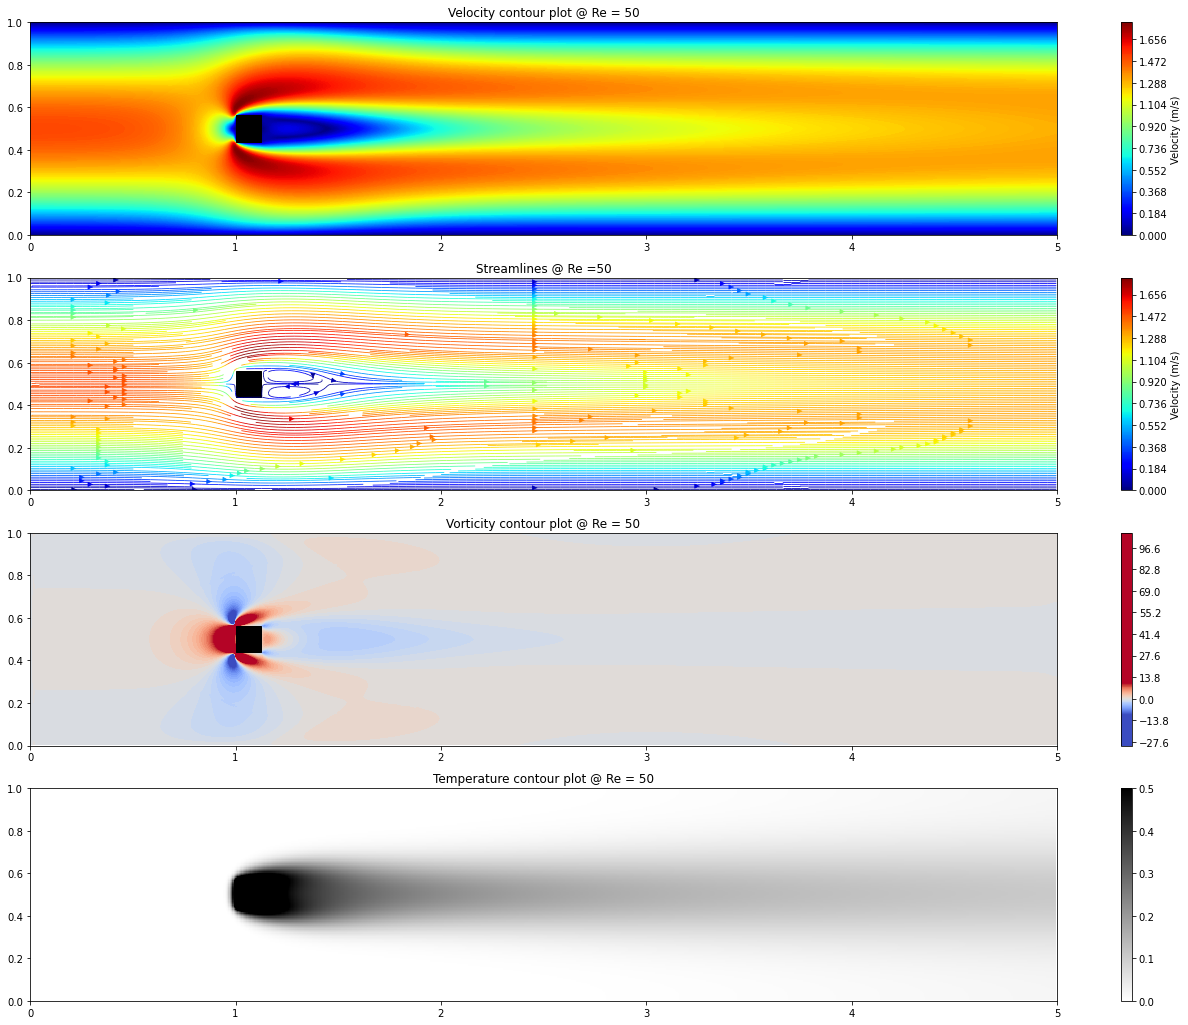

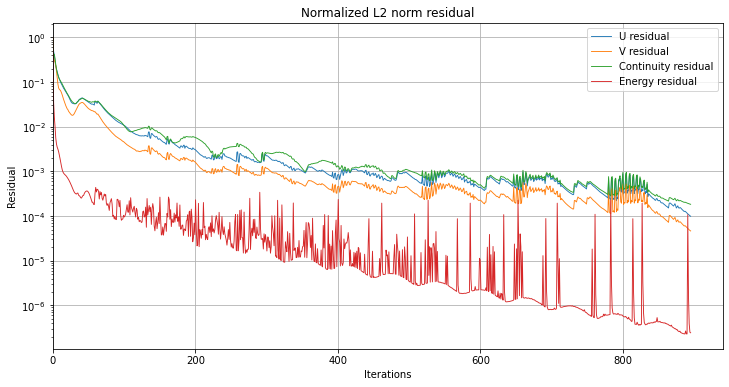

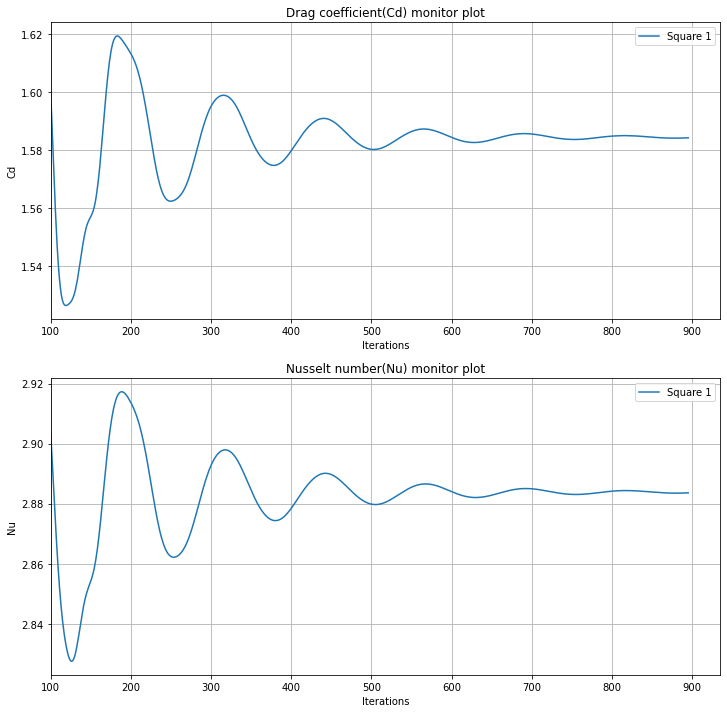

In [58]:
fig,ax=plt.subplots(4,1,figsize=(23,18)) #width x height
graph=ax[0].contourf(xx,yy,V_mag,cmap=cm.jet,levels=255)
ax[0].set_title('Velocity contour plot @ Re = '+str(Re))
fig.colorbar(graph,ax=ax[0],label='Velocity (m/s)')
ax[0].set_xlim(0,L)
ax[0].set_ylim(0,H)

ax[1].streamplot(xx,yy,U_final,V_final,density=4,color=V_mag,cmap=cm.jet,linewidth=0.8,arrowsize=1)
ax[1].set_title('Streamlines @ Re ='+str(Re))
fig.colorbar(graph,ax=ax[1],label='Velocity (m/s)')
ax[1].set_xlim(0,L)
ax[1].set_ylim(0,H)

graph=ax[2].contourf(xx,yy,vort,cmap=cm.coolwarm,levels=255,vmax=10*u_inlet,vmin=-10*u_inlet)
ax[2].set_title('Vorticity contour plot @ Re = '+str(Re))
fig.colorbar(graph,ax=ax[2])
ax[2].set_xlim(0,L)
ax[2].set_ylim(0,H)

graph=ax[3].pcolormesh(xx,yy,T_final,cmap=cm.gist_gray_r,vmax=0.5)
ax[3].set_title('Temperature contour plot @ Re = '+str(Re))
fig.colorbar(graph,ax=ax[3])
ax[3].set_xlim(0,L)
ax[3].set_ylim(0,H)

for i in range(4):
    for n in range(n_squares):
        Nx_lft=int(square_coord[0][n])
        Nx_rgt=int(square_coord[1][n])
        Ny_top=int(square_coord[2][n])
        Ny_btm=int(square_coord[3][n])
        
        rect=patches.Rectangle([Nx_lft*dx,Ny_btm*dy],size*dx,size*dy,fc='k',ec='k')
        ax[i].add_patch(rect)
    
plt.show()

iterations=np.linspace(0,len(U_res_list),len(U_res_list))
fig,ax=plt.subplots(1,1,figsize=(12,6))
plt.plot(iterations,U_res_list,label='U residual',linewidth=0.9)
plt.plot(iterations,V_res_list,label='V residual',linewidth=0.9)
plt.plot(iterations,Cont_res_list,label='Continuity residual',linewidth=0.9)
plt.plot(iterations,T_res_list,label='Energy residual',linewidth=0.9)
plt.xlabel('Iterations')
plt.ylabel('Residual')
plt.title('Normalized L2 norm residual')
ax.set_yscale('log')
plt.grid()
plt.xlim(0)
plt.legend()

plt.show()

fig,ax=plt.subplots(2,1,figsize=(12,12))
for i in range(n_squares):
    ax[0].plot(iterations[100::],cd_array[i][100:iter_total-1:],label='Square '+str(i+1))
ax[0].set_xlabel('Iterations')
ax[0].set_ylabel('Cd')
ax[0].set_title('Drag coefficient(Cd) monitor plot')
ax[0].grid()
ax[0].legend()
ax[0].set_xlim(100)

for i in range(n_squares):
    ax[1].plot(iterations[100::],Nu_array[i][100:iter_total-1:],label='Square '+str(i+1))
ax[1].set_xlabel('Iterations')
ax[1].set_ylabel('Nu')
ax[1].set_title('Nusselt number(Nu) monitor plot')
ax[1].grid()
ax[1].legend()
ax[1].set_xlim(100)

plt.show()